# Exploratory Data Analysis of Bicycle Accidents In Great Britain (1979 - 2018)

#### Load libraries and datasets

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import scikit_posthocs as sp
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
%matplotlib inline 

In [2]:
# import accidents dataset.
df_Ac = pd.read_csv('E:\Site\Data Analysis\Datasets\Bicycle Accidents UK\Accidents.csv')
df_Ac.head()

,Accident_Index,Number_of_Vehicles,Number_of_Casualties,Date,Time,Speed_limit,Road_conditions,Weather_conditions,Day,Road_type,Light_conditions
0,197901A1SEE71,2,1,1979-01-01,18:20,50.0,Snow,Unknown,Monday,Dual carriageway,Darkness lights lit
1,197901A2JDW40,1,1,1979-02-01,09:15,30.0,Snow,Unknown,Tuesday,Unknown,Daylight
2,197901A4IJV90,2,1,1979-04-01,08:45,30.0,Snow,Unknown,Thursday,Unknown,Daylight
3,197901A4NIE33,2,1,1979-04-01,13:40,30.0,Wet,Unknown,Thursday,Unknown,Daylight
4,197901A4SKO47,2,1,1979-04-01,18:50,30.0,Wet,Unknown,Thursday,Unknown,Darkness lights lit


In [3]:
# import bikers dataset
df_Bk = pd.read_csv('E:\Site\Data Analysis\Datasets\Bicycle Accidents UK\Bikers.csv')
df_Bk.head()

,Accident_Index,Gender,Severity,Age_Grp
0,197901A1SEE71,Male,Serious,36 to 45
1,197901A2JDW40,Male,Slight,46 to 55
2,197901A4IJV90,Male,Slight,46 to 55
3,197901A4NIE33,Male,Slight,36 to 45
4,197901A4SKO47,Male,Slight,46 to 55


#### Functions

In [4]:
# Check duplicates
def sum_duplicates(df):
    """Returns the number of duplicates in data"""
    sum_of_duplicates = df.duplicated().sum()
    return f"There are {sum_of_duplicates} number of duplicates"

# Check null values
def sum_null_values(df):
    """Returns the number of null values in data"""
    sum_of_null_values = df.isnull().sum()
    return sum_of_null_values

# Set index of dataset
def change_index(df,df_col,drop_index=True):
    """Returns data with df_col as index"""
    df = df.set_index(df_col,drop=drop_index)
    return df

# Summary statistics of quantitative data
def sum_stats(df,df_col):
    """Returns the measures of central tendency and spread"""
    
    # Mean of number of vehicles
    df_mean = df[df_col].mean()

    # Median of number of vehicles
    df_median = df[df_col].median()
    df_25_centile = np.percentile(df[df_col], 25)
    df_75_centile = np.percentile(df[df_col], 75)

    # Mode of number of vehicles
    df_mode = stats.mode(df[df_col])

    # Variance of number of vehicles
    df_var = df[df_col].var()

    # Standard deviation of number of vehicles
    df_std = df[df_col].std()

    # Range of number of vehicles
    df_range = df[df_col].max() - df[df_col].min() 

    # IQR of number of vehicles 
    qt_75 = df[df_col].quantile(0.75)
    qt_25 = df[df_col].quantile(0.25) 
    df_iqr = qt_75 - qt_25


    print(f'Mean: {df_mean}')
    print(f'25th Percentile: {df_25_centile} | Median: {df_median} | 75th Percentile: {df_75_centile}')
    print(f'Mode: {df_mode.mode} | Count: {df_mode.count}')
    print(f'Variance: {df_var}')
    print(f'Std Dev.: {df_std}')
    print(f'Range: {df_range}')
    print(f'IQR: {qt_75}(75th Quantile) - {qt_25}(25th Qauntile)  = {df_iqr}')


# Get frequency of individual values categorical data
def get_value_count(df,df_col):
    """Returns count of value types"""
    df = pd.DataFrame(df[df_col].value_counts())
    return df

# Get frequency and percentage of column
def get_count_percent(df,df_col):
    """Returns frequency of column"""
    df = pd.DataFrame({
    'Count (n)': df[df_col].value_counts(),
    'Percentage (%)': df[df_col].value_counts(normalize=True) * 100
    })
    return df

# Perform normality test on data
# check_normality(df['column'], 'column')
def check_normality(data, column_name):
    """Comprehensive normality check"""
    
    print(f"\n{'='*50}")
    print(f"Normality Tests for: {column_name}")
    print(f"{'='*50}")
    
    # 1. Shapiro-Wilk (best for n < 5000)
    stat, p = stats.shapiro(data)
    print(f"\nShapiro-Wilk Test:")
    print(f"  Statistic: {stat:.4f}")
    print(f"  P-value: {p:.4f}")
    print(f"  Normal? {'Yes' if p > 0.05 else 'No'}")
    
    # 2. Kolmogorov-Smirnov
    stat, p = stats.kstest(data, 'norm', args=(data.mean(), data.std()))
    print(f"\nKolmogorov-Smirnov Test:")
    print(f"  Statistic: {stat:.4f}")
    print(f"  P-value: {p:.4f}")
    print(f"  Normal? {'Yes' if p > 0.05 else 'No'}")
    
    # 5. Skewness and Kurtosis
    skew = stats.skew(data)
    kurt = stats.kurtosis(data)
    print(f"\nDescriptive Statistics:")
    print(f"  Skewness: {skew:.4f} (normal ≈ 0. -1 to +1)")
    print(f"  Kurtosis: {kurt:.4f} (normal ≈ 0. -1 to +1)")

# Get frequency of crossed columns
def count_cross_tabs(df,df_col_one,df_col_two):
    """Returns frequency of cross tabs"""
    df = pd.crosstab(df[df_col_one],df[df_col_two])
    return df

# Get percentage of crossed columns
def percent_cross_tabs(df,df_col_one,df_col_two):
    """Returns percentage of cross tabs"""
    df = pd.crosstab(df[df_col_one],df[df_col_two], normalize='index') * 100
    return df

# Get statistics of group by table
def stats_groupby(df,df_col_one,df_col_two):
    """Returns the aggregate statistics of two variables"""
    df = pd.DataFrame(df.groupby(df_col_one)[df_col_two].agg(['median', 'mean', 'count','sum'])).sort_values('count')
    df['percentage'] = (df['count'] / df['count'].sum()) * 100
    return df


# Run Kruskal-Wallis H test
def run_kruskal_wallis(df,df_col_one,df_col_two):
    """Returns the result of the Kruskal Wallis test"""
    df_test_columns = df[[df_col_one,df_col_two]]
    df_grp_by = df_test_columns.groupby([df_col_one])
    df_data = []
    for name, group in df_grp_by:
        df_data.append(group[df_col_two].values)

    df_result = stats.kruskal(*df_data)
    
    if df_result.pvalue >= 0.05:
        print(f'K-H statistic: {df_result.statistic} \np-value: {df_result.pvalue} \nThe relationship/difference may not be significant')
    elif df_result.pvalue < 0.05:
        # Run Dunn's test and epsilon sq. if difference/relationship is significant
        dunn_result = run_dunn_test(df,df_col_one,df_col_two)
        epsilon_sq = run_epsilon_sq(df_result.statistic, len(df))
        kruskal_result_dict = {
            'H_stat': df_result.statistic,
            'p_val': df_result.pvalue,
            'comment': 'The relationship/difference may be significant',
            'dunn_posthoc': dunn_result,
            'epsilon_sq': epsilon_sq
        }
        return kruskal_result_dict
        # print(f'K-H statistic: {df_result.statistic} \np-value: {df_result.pvalue} \nThe relationship/difference may be significant')
        

# Run posthoc on Kruskal-Wallis(Dunn's test with bonferroni)
def run_dunn_test(df,df_col_one,df_col_two):
    """Returns Dunn's posthoc results"""
    dunn_matrix = sp.posthoc_dunn(
            df,
            val_col= df_col_two,
            group_col=df_col_one,
            p_adjust='bonferroni'  # good default; less conservative than Bonferroni
        )
    return dunn_matrix

def run_epsilon_sq(h_stat,sample_size):
    """Returns epsilon squared, the effect size for Kruskal-Wallis
    This based on a formular from Statistical reasoning in the behavioral sciences (7th ed.)
    Page 387"""
    
    denominator_one = (sample_size**2 - 1)
    denominator_two = (sample_size + 1)

    epsilon_squared_rank = h_stat / (denominator_one / denominator_two)
    return epsilon_squared_rank

# Run the Chi-square test 
def run_chi_square(df,df_col_one,df_col_two):
    """Returns the result of the Chi-square test"""
    cross_tabs = pd.crosstab(df[df_col_one], df[df_col_two])
    cross_tabs_result = stats.chi2_contingency(cross_tabs)
    exp_val_check = len(cross_tabs_result.expected_freq[cross_tabs_result.expected_freq < 5])/len(cross_tabs_result.expected_freq) * 100
    
    result_dict= {}
    if cross_tabs_result.pvalue >= 0.05:
        result_dict = {
            "comment" : 'Difference or relationship not significant',
            "chi_statistic" : cross_tabs_result.statistic,
            "pvalue" : cross_tabs_result.pvalue,
            "dof" : cross_tabs_result.dof,
            "percent_exp_vals_<_5": exp_val_check,
            "cross_tab" : cross_tabs,
            "expected" : cross_tabs_result.expected_freq
        } 
    elif cross_tabs_result.pvalue < 0.05 and exp_val_check < 20:
        # Run cramer's v and pearson's residuals if relationship is statistically significant
        cramers_v = stats.contingency.association(cross_tabs, method="cramer")
        residuals = run_pearson_residual(cross_tabs, cross_tabs_result.expected_freq)
        result_dict = {
            "comment" : 'Difference or relationship is significant',
            "chi_statistic" : cross_tabs_result.statistic,
            "pvalue" : cross_tabs_result.pvalue,
            "dof" : cross_tabs_result.dof,
            "percent_exp_vals_<_5": exp_val_check,
            "cross_tab" : cross_tabs,
            "expected" : cross_tabs_result.expected_freq,
            "cramers_v" : cramers_v,
            "residuals": residuals
        }
    elif cross_tabs_result.pvalue < 0.05 and exp_val_check > 20:
        result_dict = {
            "comment" : 'Difference or relationship is significant but assumption for expected values in Chi-test failed',
            "chi_statistic" : cross_tabs_result.statistic,
            "pvalue" : cross_tabs_result.pvalue,
            "dof" : cross_tabs_result.dof,
            "percent_exp_vals_<_5": exp_val_check,
            "cross_tab" : cross_tabs,
            "expected" : cross_tabs_result.expected_freq
        }
    
    return result_dict

def run_pearson_residual(obv_data, exptd_data):
    """Runs the Pearson residual to from observed and expected, formula from 
    Practical Statistics for Data Scientists, 2nd Edition, Bruce P. et al(p. 125)"""
    diff_obv_exptd = obv_data - exptd_data
    residuals = diff_obv_exptd / np.sqrt(exptd_data)

    return residuals

### Descriptive Statistics

#### Get summary of accident dataset

In [5]:
# get shape of accidents dataset
df_Ac.shape

(827861, 11)

In [6]:
# get information about columns and datatypes for accidents dataset
df_Ac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827861 entries, 0 to 827860
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Accident_Index        827861 non-null  object 
 1   Number_of_Vehicles    827861 non-null  int64  
 2   Number_of_Casualties  827861 non-null  int64  
 3   Date                  827861 non-null  object 
 4   Time                  827861 non-null  object 
 5   Speed_limit           827861 non-null  float64
 6   Road_conditions       827861 non-null  object 
 7   Weather_conditions    827861 non-null  object 
 8   Day                   827861 non-null  object 
 9   Road_type             827861 non-null  object 
 10  Light_conditions      827861 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 69.5+ MB


In [7]:
# get numerical summary of accidents dataset
df_Ac.describe()

,Number_of_Vehicles,Number_of_Casualties,Speed_limit
count,827861.000000,827861.000000,827861.000000
mean,1.986178,1.047212,33.340934
std,0.311600,0.253509,9.278129
min,1.000000,1.000000,0.000000
25%,2.000000,1.000000,30.000000
50%,2.000000,1.000000,30.000000
75%,2.000000,1.000000,30.000000
max,13.000000,60.000000,660.000000


#### Data Cleaning for Accidents Dataset

In [8]:
# check the number of duplicates
sum_duplicates(df_Ac)

'There are 0 number of duplicates'

In [9]:
# check the number of null values
sum_null_values(df_Ac)

Accident_Index          0
Number_of_Vehicles      0
Number_of_Casualties    0
Date                    0
Time                    0
Speed_limit             0
Road_conditions         0
Weather_conditions      0
Day                     0
Road_type               0
Light_conditions        0
dtype: int64

In [10]:
# backup original dataset before cleaning
df_Ac_clean = df_Ac
df_Ac_clean.head()

,Accident_Index,Number_of_Vehicles,Number_of_Casualties,Date,Time,Speed_limit,Road_conditions,Weather_conditions,Day,Road_type,Light_conditions
0,197901A1SEE71,2,1,1979-01-01,18:20,50.0,Snow,Unknown,Monday,Dual carriageway,Darkness lights lit
1,197901A2JDW40,1,1,1979-02-01,09:15,30.0,Snow,Unknown,Tuesday,Unknown,Daylight
2,197901A4IJV90,2,1,1979-04-01,08:45,30.0,Snow,Unknown,Thursday,Unknown,Daylight
3,197901A4NIE33,2,1,1979-04-01,13:40,30.0,Wet,Unknown,Thursday,Unknown,Daylight
4,197901A4SKO47,2,1,1979-04-01,18:50,30.0,Wet,Unknown,Thursday,Unknown,Darkness lights lit


In [11]:
# set index of dataframe
df_Ac_clean = change_index(df_Ac,'Accident_Index',False)
df_Ac_clean

,Accident_Index,Number_of_Vehicles,Number_of_Casualties,Date,Time,Speed_limit,Road_conditions,Weather_conditions,Day,Road_type,Light_conditions
Accident_Index,,,,,,,,,,,
197901A1SEE71,197901A1SEE71,2,1,1979-01-01,18:20,50.0,Snow,Unknown,Monday,Dual carriageway,Darkness lights lit
197901A2JDW40,197901A2JDW40,1,1,1979-02-01,09:15,30.0,Snow,Unknown,Tuesday,Unknown,Daylight
197901A4IJV90,197901A4IJV90,2,1,1979-04-01,08:45,30.0,Snow,Unknown,Thursday,Unknown,Daylight
197901A4NIE33,197901A4NIE33,2,1,1979-04-01,13:40,30.0,Wet,Unknown,Thursday,Unknown,Daylight
197901A4SKO47,197901A4SKO47,2,1,1979-04-01,18:50,30.0,Wet,Unknown,Thursday,Unknown,Darkness lights lit
...,...,...,...,...,...,...,...,...,...,...,...
2018983118818,2018983118818,2,1,2018-02-07,14:55,30.0,Dry,Clear,Monday,Single carriageway,Daylight
2018983119218,2018983119218,2,1,2018-07-24,07:45,30.0,Dry,Clear,Tuesday,Single carriageway,Daylight
2018983120618,2018983120618,2,1,2018-10-08,13:25,20.0,Dry,Clear,Friday,Single carriageway,Daylight


In [12]:
# Change the type of Date from object to datetime
df_Ac_clean_Date = pd.to_datetime(df_Ac_clean["Date"], format="%Y-%m-%d", errors="raise")
df_Ac_clean['Date'] = df_Ac_clean_Date

# Create combined DateTime column
# df_Ac_clean["AccidentDateTime"] = pd.to_datetime(
#     df_Ac_clean["Date"].astype(str) + " " + df_Ac_clean["Time"].astype(str),
#     format="%Y-%m-%d %H:%M",
#     errors="raise"
# )

In [13]:
# Find inconsistent values in Road conditions column
get_value_count(df_Ac_clean, 'Road_conditions')

,count
Road_conditions,
Dry,633936
Wet,184279
Frost,6020
Snow,1710
Missing Data,1648
Flood,268


In [14]:
# Find inconsistent values in Weather conditions column
get_value_count(df_Ac_clean, 'Weather_conditions')

,count
Weather_conditions,
Clear,683162
Rain,82007
Unknown,24081
Clear and windy,11891
Other,11820
Rain and windy,8808
Fog,3369
Snow,2086
Snow and windy,483


In [15]:
# Change 'Missing data' entries to 'Unknown'
df_Ac_clean['Weather_conditions'] = df_Ac_clean['Weather_conditions'].replace('Missing data', 'Unknown')

In [16]:
# Find inconsistent values in Day column
get_value_count(df_Ac_clean, 'Day')

,count
Day,
Wednesday,136756
Tuesday,136534
Thursday,136263
Friday,132066
Monday,125749
Saturday,87652
Sunday,72841


In [17]:
# Find inconsistent values in Road type column
get_value_count(df_Ac_clean, 'Road_type')

,count
Road_type,
Single carriageway,656703
Roundabout,75066
Dual carriageway,59037
Unknown,30647
One way sreet,5562
Slip road,846


In [18]:
# Change 'One way sreet' entries to 'One way street'
df_Ac_clean['Road_type'] = df_Ac_clean['Road_type'].replace('One way sreet', 'One way street')

In [19]:
# Find inconsistent values in light conditions column
get_value_count(df_Ac_clean, 'Light_conditions')

,count
Light_conditions,
Daylight,660657
Darkness lights lit,142039
Darkness no lights,25165


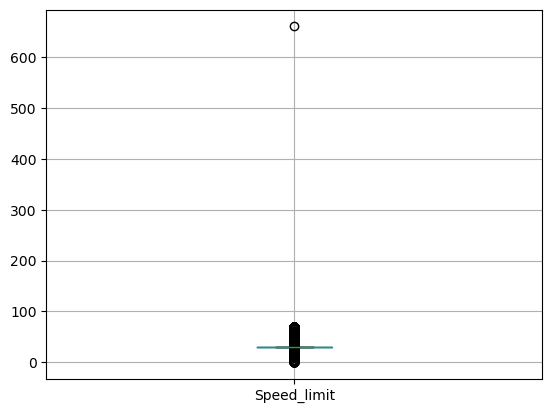

In [20]:
# Boxplot of Speed limit column
df_Ac_clean.boxplot(column=['Speed_limit'])
plt.show()

In [21]:
# Handle outliers in speed limit column
# UK speed limits are between 20mph and 70mph. 
# The value of 660 can be treated as a typographical error and replaced with 66mph, 60mph or the mean.

df_Ac_clean[df_Ac_clean['Speed_limit'] > 600]
df_Ac_clean.at['199032C064990','Speed_limit'] = 66
df_Ac_clean.at['199032C064990','Speed_limit']

np.float64(66.0)

In [22]:
# Check validity of number of casualties and number of vehicles

df_Ac_clean[df_Ac_clean['Number_of_Casualties'] == 0]
df_Ac_clean[df_Ac_clean['Number_of_Vehicles'] == 0]

,Accident_Index,Number_of_Vehicles,Number_of_Casualties,Date,Time,Speed_limit,Road_conditions,Weather_conditions,Day,Road_type,Light_conditions
Accident_Index,,,,,,,,,,,


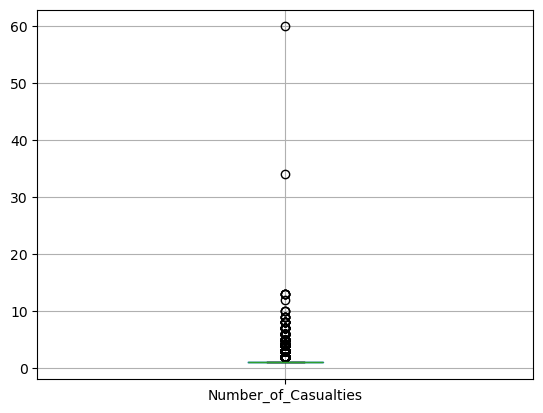

In [23]:
# Boxplot of number of casualties
# Some values can be considered as outliers visually and using the IQR
# They were however not removed because it is possible that accidents tragically may involve such casualties

df_Ac_clean.boxplot(column=['Number_of_Casualties'])
plt.show()

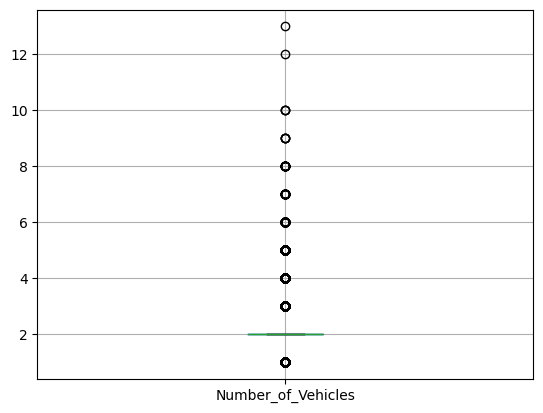

In [24]:
# Boxplot of number of vehicles
# Some values can be considered as outliers visually and using the IQR
# They were however not removed because it is possible that accidents tragically may involve such number of vehicles
df_Ac_clean.boxplot(column=['Number_of_Vehicles'])
plt.show()

#### Get summary of Bikers dataset

In [25]:
# get shape of bikers dataset
df_Bk.shape

(827871, 4)

In [26]:
# get numerical summary of bikers dataset
df_Bk.describe()

,Accident_Index,Gender,Severity,Age_Grp
count,827871,827871,827871,827871
unique,827871,3,3,9
top,2018983133818,Male,Slight,11 to 15
freq,1,660031,681578,169945


In [27]:
# get information about columns and datatypes for bikers dataset
df_Bk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827871 entries, 0 to 827870
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Accident_Index  827871 non-null  object
 1   Gender          827871 non-null  object
 2   Severity        827871 non-null  object
 3   Age_Grp         827871 non-null  object
dtypes: object(4)
memory usage: 25.3+ MB


#### Data cleaning for Bikers dataset

In [28]:
# check the number of duplicates
sum_duplicates(df_Bk)

'There are 0 number of duplicates'

In [29]:
# check the number of null values
sum_null_values(df_Bk)

Accident_Index    0
Gender            0
Severity          0
Age_Grp           0
dtype: int64

In [30]:
# Find inconsistent values in the gender column
get_value_count(df_Bk, 'Gender')

,count
Gender,
Male,660031
Female,167721
Other,119


In [31]:
# Find inconsistent values in the severity column
get_value_count(df_Bk, 'Severity')

,count
Severity,
Slight,681578
Serious,139563
Fatal,6730


In [32]:
# Find inconsistent values in the age group column
get_value_count(df_Bk, 'Age_Grp')

,count
Age_Grp,
11 to 15,169945
26 to 35,145081
16 to 20,122604
36 to 45,103774
21 to 25,87292
46 to 55,73578
6 to 10,68021
56 to 65,41913
66 to 75,15663


In [33]:
# backup original dataset before cleaning
df_Bk_clean = df_Bk
df_Bk_clean.head()

,Accident_Index,Gender,Severity,Age_Grp
0,197901A1SEE71,Male,Serious,36 to 45
1,197901A2JDW40,Male,Slight,46 to 55
2,197901A4IJV90,Male,Slight,46 to 55
3,197901A4NIE33,Male,Slight,36 to 45
4,197901A4SKO47,Male,Slight,46 to 55


In [34]:
# set index of dataframe
df_Bk_clean = change_index(df_Bk_clean,'Accident_Index')
df_Bk_clean.head()

,Gender,Severity,Age_Grp
Accident_Index,,,
197901A1SEE71,Male,Serious,36 to 45
197901A2JDW40,Male,Slight,46 to 55
197901A4IJV90,Male,Slight,46 to 55
197901A4NIE33,Male,Slight,36 to 45
197901A4SKO47,Male,Slight,46 to 55


In [35]:
# Categorize time of the day into traffic status

# Morning Rush Hour: 7-9
# Inter Peak: 10-15
# Afternoon School Pickup: 15-16
# Evening Rush Hour: 17-19
# Late Evening: 19+

df_Ac_clean['Traffic_status'] = df_Ac_clean["Time"].str.split(':').str[0].astype(int).apply(
    lambda x: 
        'Morning Rush Hour' if (7 <= x <= 9) else (
        'Day Off-Peak' if (10 <= x <= 14) else (
        'Afternoon School Pickup' if (15 <= x <= 16) else (
        'Evening Rush Hour' if (17 <= x <= 19) else (
        'Night/Dawn Off-Peak'))))
)
df_Ac_clean.head(10)

,Accident_Index,Number_of_Vehicles,Number_of_Casualties,Date,Time,Speed_limit,Road_conditions,Weather_conditions,Day,Road_type,Light_conditions,Traffic_status
Accident_Index,,,,,,,,,,,,
197901A1SEE71,197901A1SEE71,2,1,1979-01-01,18:20,50.0,Snow,Unknown,Monday,Dual carriageway,Darkness lights lit,Evening Rush Hour
197901A2JDW40,197901A2JDW40,1,1,1979-02-01,09:15,30.0,Snow,Unknown,Tuesday,Unknown,Daylight,Morning Rush Hour
197901A4IJV90,197901A4IJV90,2,1,1979-04-01,08:45,30.0,Snow,Unknown,Thursday,Unknown,Daylight,Morning Rush Hour
197901A4NIE33,197901A4NIE33,2,1,1979-04-01,13:40,30.0,Wet,Unknown,Thursday,Unknown,Daylight,Day Off-Peak
197901A4SKO47,197901A4SKO47,2,1,1979-04-01,18:50,30.0,Wet,Unknown,Thursday,Unknown,Darkness lights lit,Evening Rush Hour
197901A5CKE54,197901A5CKE54,2,1,1979-05-01,02:50,40.0,Snow,Unknown,Friday,Dual carriageway,Darkness lights lit,Night/Dawn Off-Peak
197901A5UJC75,197901A5UJC75,2,1,1979-05-01,20:45,30.0,Wet,Unknown,Friday,Single carriageway,Darkness lights lit,Night/Dawn Off-Peak
197901A6ODP50,197901A6ODP50,2,1,1979-06-01,14:15,70.0,Snow,Unknown,Saturday,Unknown,Daylight,Day Off-Peak
197901A6VEC34,197901A6VEC34,2,1,1979-06-01,21:20,30.0,Wet,Unknown,Saturday,Roundabout,Darkness lights lit,Night/Dawn Off-Peak


In [36]:
# Merge the accidents and bikers tables

df_Ac_merge = df_Ac_clean.drop('Accident_Index', axis=1)
df_Ac_Bk_clean = pd.merge(df_Ac_merge, df_Bk_clean, on='Accident_Index', how='left')
df_Ac_Bk_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 827861 entries, 197901A1SEE71 to 2018983133818
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Number_of_Vehicles    827861 non-null  int64         
 1   Number_of_Casualties  827861 non-null  int64         
 2   Date                  827861 non-null  datetime64[ns]
 3   Time                  827861 non-null  object        
 4   Speed_limit           827861 non-null  float64       
 5   Road_conditions       827861 non-null  object        
 6   Weather_conditions    827861 non-null  object        
 7   Day                   827861 non-null  object        
 8   Road_type             827861 non-null  object        
 9   Light_conditions      827861 non-null  object        
 10  Traffic_status        827861 non-null  object        
 11  Gender                827861 non-null  object        
 12  Severity              827861 non-null  objec

#### Univariate Analysis of Bikers Dataset

In [37]:
# Distribution of injury severity
df_Bk_severity_dist = get_count_percent(df_Bk_clean,'Severity')
df_Bk_severity_dist

,Count (n),Percentage (%)
Severity,,
Slight,681578,82.329010
Serious,139563,16.858061
Fatal,6730,0.812929


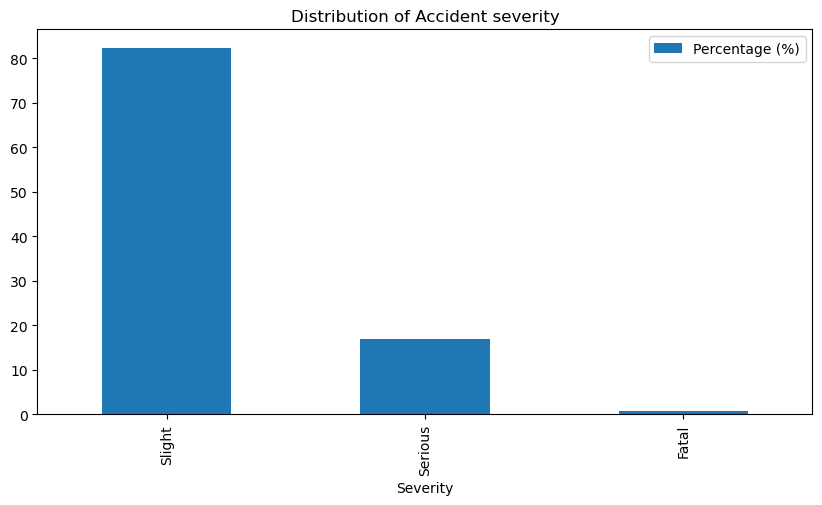

In [38]:
# Bar chart of severity distribution

df_Bk_severity_dist.plot(kind='bar', y='Percentage (%)', title='Distribution of Accident severity', figsize=(10,5))
plt.show()

In [39]:
# Distribution of casualties by gender
df_Bk_gender_dist = get_count_percent(df_Bk_clean,'Gender')
df_Bk_gender_dist

,Count (n),Percentage (%)
Gender,,
Male,660031,79.726310
Female,167721,20.259316
Other,119,0.014374


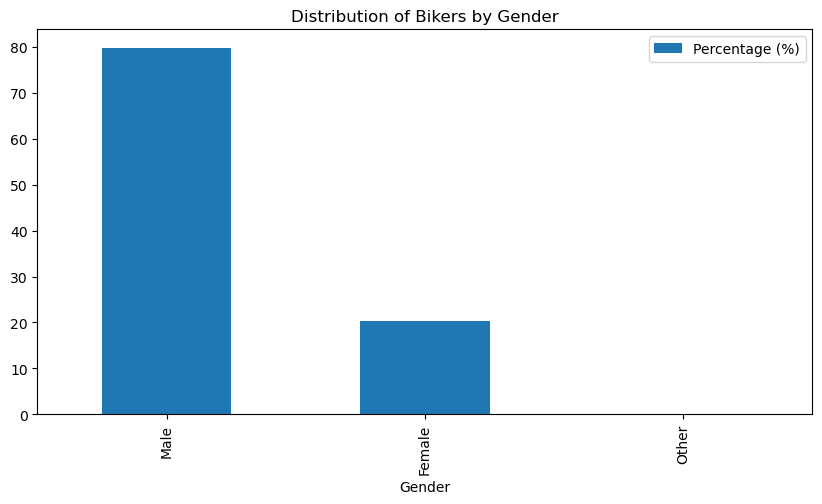

In [40]:
# Bar chart of gender distribution
df_Bk_gender_dist.plot(kind='bar', y='Percentage (%)', title='Distribution of Bikers by Gender', figsize=(10,5))
plt.show()

In [41]:
# Distribution of casualties by age group
df_Bk_age_grp_dist = get_count_percent(df_Bk_clean,'Age_Grp')
df_Bk_age_grp_dist

,Count (n),Percentage (%)
Age_Grp,,
11 to 15,169945,20.527957
26 to 35,145081,17.524590
16 to 20,122604,14.809554
36 to 45,103774,12.535045
21 to 25,87292,10.544155
46 to 55,73578,8.887617
6 to 10,68021,8.216377
56 to 65,41913,5.062745
66 to 75,15663,1.891961


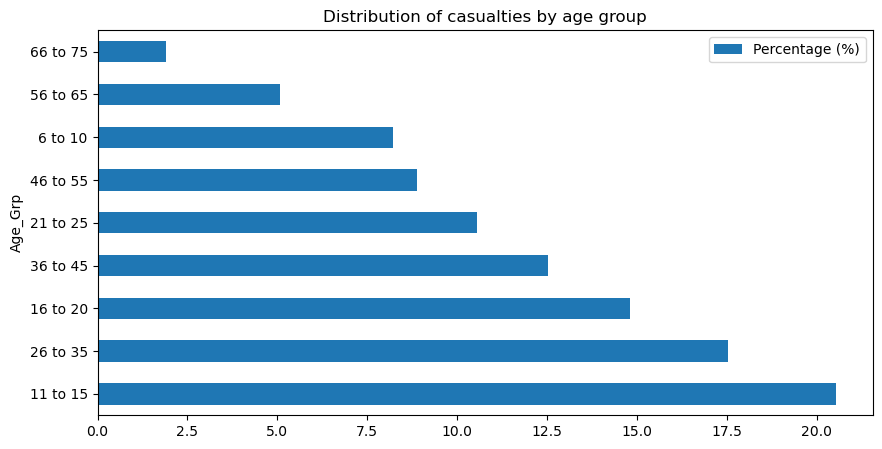

In [42]:
# Bar chart of age group distribution
df_Bk_age_grp_dist.plot(kind='barh', y='Percentage (%)', title='Distribution of casualties by age group', figsize=(10,5))
plt.show()

#### Univariate Analysis of Accident Dataset

In [43]:
sum_stats(df_Ac_clean,'Number_of_Vehicles')

Mean: 1.9861776312690174
25th Percentile: 2.0 | Median: 2.0 | 75th Percentile: 2.0
Mode: 2 | Count: 758784
Variance: 0.09709471484820836
Std Dev.: 0.3116002484726358
Range: 12
IQR: 2.0(75th Quantile) - 2.0(25th Qauntile)  = 0.0


In [44]:
sum_stats(df_Ac_clean,'Number_of_Casualties')

Mean: 1.0472120319715508
25th Percentile: 1.0 | Median: 1.0 | 75th Percentile: 1.0
Mode: 1 | Count: 792685
Variance: 0.06426656407018987
Std Dev.: 0.25350850887137866
Range: 59
IQR: 1.0(75th Quantile) - 1.0(25th Qauntile)  = 0.0


In [45]:
sum_stats(df_Ac_clean,'Speed_limit')

Mean: 33.34021653393504
25th Percentile: 30.0 | Median: 30.0 | 75th Percentile: 30.0
Mode: 30.0 | Count: 686784
Variance: 85.6106096852816
Std Dev.: 9.252600158078895
Range: 70.0
IQR: 30.0(75th Quantile) - 30.0(25th Qauntile)  = 0.0


In [46]:
# Distribution of road conditions during accidents
df_Ac_road_cond_dist = get_count_percent(df_Ac_clean,'Road_conditions')
df_Ac_road_cond_dist

,Count (n),Percentage (%)
Road_conditions,,
Dry,633936,76.575174
Wet,184279,22.259655
Frost,6020,0.727175
Snow,1710,0.206556
Missing Data,1648,0.199067
Flood,268,0.032373


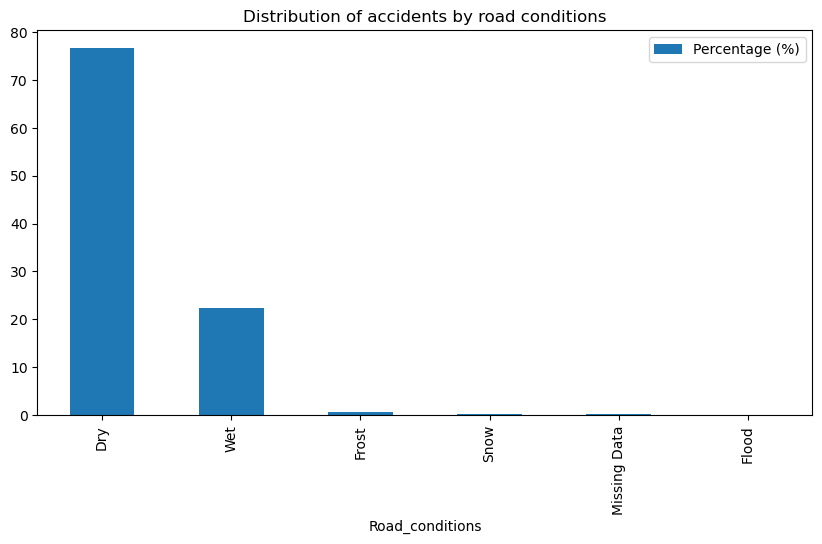

In [47]:
# Bar chart for distribution of road conditions
df_Ac_road_cond_dist.plot(kind='bar', y='Percentage (%)',title = 'Distribution of accidents by road conditions', figsize=(10, 5))
plt.show()

In [48]:
# Distribution of weather conditions during accidents
df_Ac_weather_cond_dist = get_count_percent(df_Ac_clean,'Weather_conditions')
df_Ac_weather_cond_dist

,Count (n),Percentage (%)
Weather_conditions,,
Clear,683162,82.521341
Rain,82007,9.905890
Unknown,24235,2.927424
Clear and windy,11891,1.436352
Other,11820,1.427776
Rain and windy,8808,1.063947
Fog,3369,0.406952
Snow,2086,0.251975
Snow and windy,483,0.058343


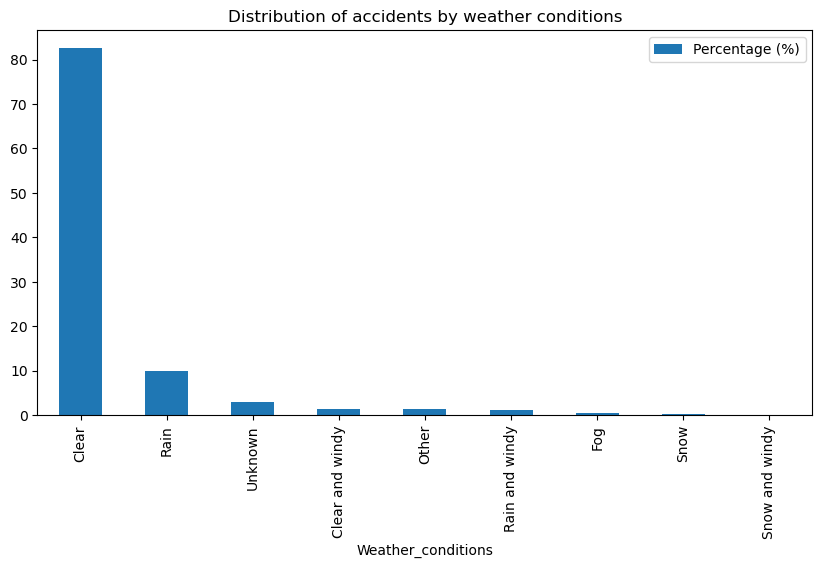

In [49]:
# Bar chart of the distribution of weather conditions
df_Ac_weather_cond_dist.plot(kind='bar', y='Percentage (%)', title ='Distribution of accidents by weather conditions', figsize=(10,5))
plt.show()

In [50]:
# Distribution of days of the week accidents happened
df_Ac_days_dist = get_count_percent(df_Ac_clean,'Day')
df_Ac_days_dist

,Count (n),Percentage (%)
Day,,
Wednesday,136756,16.519198
Tuesday,136534,16.492382
Thursday,136263,16.459647
Friday,132066,15.952678
Monday,125749,15.189627
Saturday,87652,10.587768
Sunday,72841,8.798699


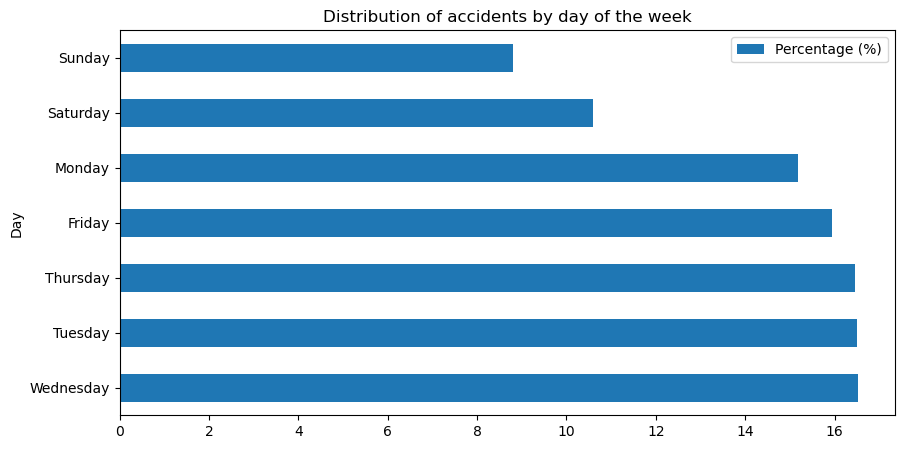

In [51]:
# Bar chart for distribution by day
df_Ac_days_dist.plot(kind='barh', y='Percentage (%)', title = 'Distribution of accidents by day of the week', figsize=(10,5))
plt.show()

In [52]:
# Distribution of the roads on which happened
df_Ac_road_type_dist = get_count_percent(df_Ac_clean,'Road_type')
df_Ac_road_type_dist

,Count (n),Percentage (%)
Road_type,,
Single carriageway,656703,79.325273
Roundabout,75066,9.067464
Dual carriageway,59037,7.131270
Unknown,30647,3.701950
One way street,5562,0.671852
Slip road,846,0.102191


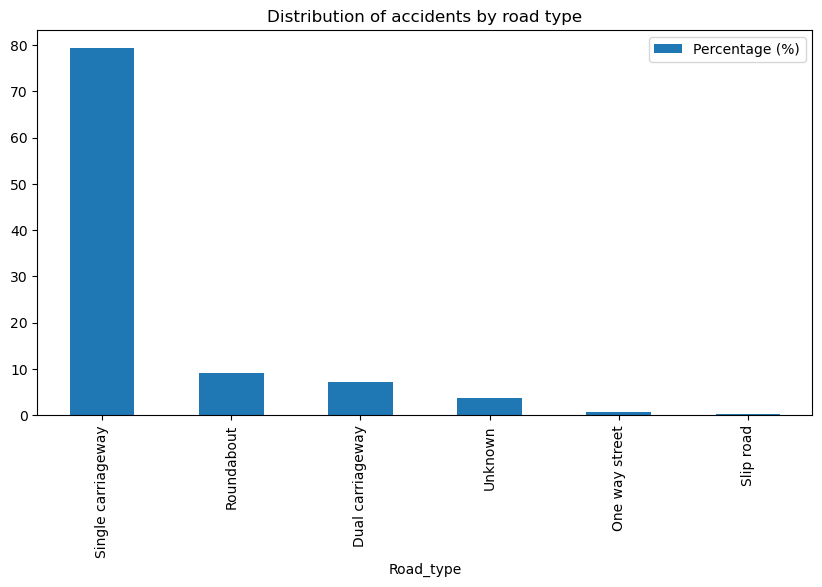

In [53]:
# Bar chart for distribution by road type
df_Ac_road_type_dist.plot(kind='bar', y='Percentage (%)',title = 'Distribution of accidents by road type', figsize=(10,5))
plt.show()

In [54]:
# Distribution of the light conditions during accidents
df_Ac_light_condition_dist = get_count_percent(df_Ac_clean,'Light_conditions')
df_Ac_light_condition_dist

,Count (n),Percentage (%)
Light_conditions,,
Daylight,660657,79.802890
Darkness lights lit,142039,17.157349
Darkness no lights,25165,3.039762


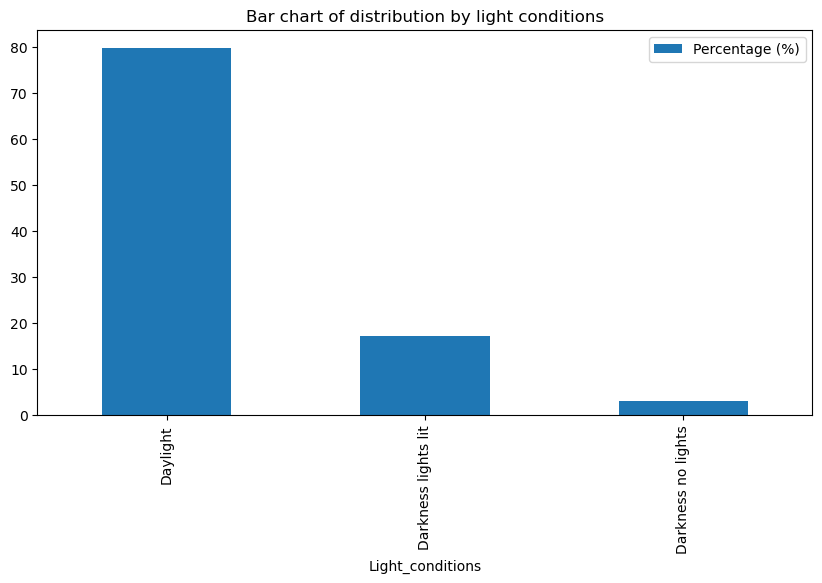

In [55]:
# Bar chart of accident distribution by light condtions
df_Ac_light_condition_dist.plot(kind='bar', y='Percentage (%)', title = 'Bar chart of distribution by light conditions', figsize=(10,5))
plt.show()

##### Normality Tests

In [56]:
# Statistical test for normality of Number of vehicles
check_normality(df_Ac_clean['Number_of_Vehicles'], 'Number_of_Vehicles')


Normality Tests for: Number_of_Vehicles

Shapiro-Wilk Test:
  Statistic: 0.3691
  P-value: 0.0000
  Normal? No

Kolmogorov-Smirnov Test:
  Statistic: 0.4672
  P-value: 0.0000
  Normal? No

Descriptive Statistics:
  Skewness: 1.1493 (normal ≈ 0. -1 to +1)
  Kurtosis: 27.3324 (normal ≈ 0. -1 to +1)


D:\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 827861.
  res = hypotest_fun_out(*samples, **kwds)


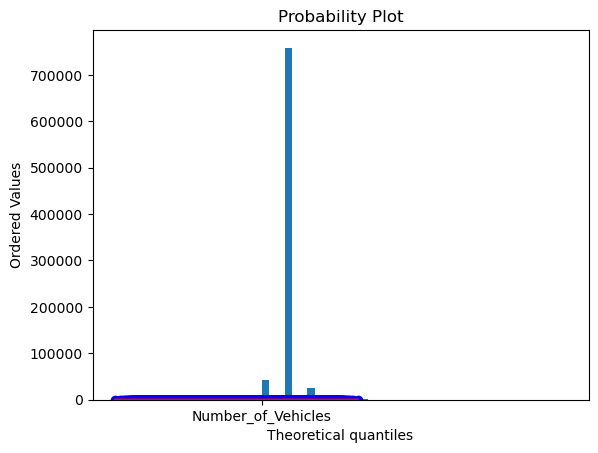

In [57]:
# Visual test for normality - Histogram/Boxplot/Q-Q plot of number of vehicles

# The data can be considered to have a non-uniform distribution from visual methods

df_Ac_clean['Number_of_Vehicles'].hist(bins=40)
df_Ac_clean['Number_of_Vehicles'].plot(kind='box')
stats.probplot(df_Ac_clean['Number_of_Vehicles'], dist="norm", plot=plt)
plt.show()

In [58]:
# Statistical test for normality of Number of casualties
check_normality(df_Ac_clean['Number_of_Casualties'], 'Number_of_Casualties')


Normality Tests for: Number_of_Casualties

Shapiro-Wilk Test:
  Statistic: 0.1738
  P-value: 0.0000
  Normal? No

Kolmogorov-Smirnov Test:
  Statistic: 0.5314
  P-value: 0.0000
  Normal? No

Descriptive Statistics:
  Skewness: 24.5344 (normal ≈ 0. -1 to +1)
  Kurtosis: 3978.0675 (normal ≈ 0. -1 to +1)


D:\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 827861.
  res = hypotest_fun_out(*samples, **kwds)


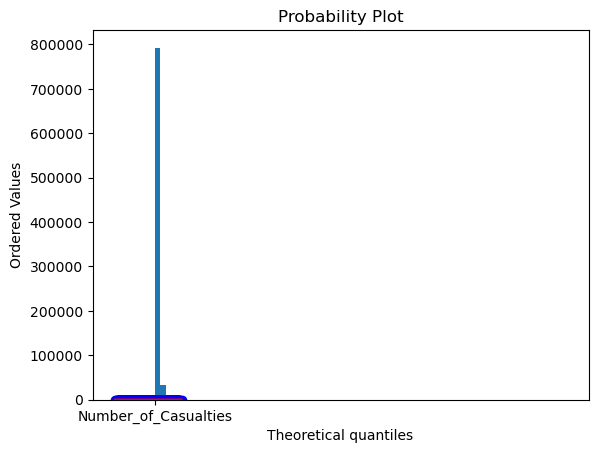

In [59]:
# Visual test for normality - Histogram/Boxplot/Q-Q plot of number of casualties

# The data can be considered to have a non-uniform distribution from visual methods

df_Ac_clean['Number_of_Casualties'].hist(bins=80)
df_Ac_clean['Number_of_Casualties'].plot(kind='box')
stats.probplot(df_Ac_clean['Number_of_Casualties'], dist="norm", plot=plt)
plt.show()

In [60]:
# Statistical test for normality for speed limit
check_normality(df_Ac_clean['Speed_limit'], 'Speed_limit')


Normality Tests for: Speed_limit

Shapiro-Wilk Test:
  Statistic: 0.4661
  P-value: 0.0000
  Normal? No

Kolmogorov-Smirnov Test:
  Statistic: 0.4839
  P-value: 0.0000
  Normal? No

Descriptive Statistics:
  Skewness: 2.5323 (normal ≈ 0. -1 to +1)
  Kurtosis: 5.4532 (normal ≈ 0. -1 to +1)


D:\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 827861.
  res = hypotest_fun_out(*samples, **kwds)


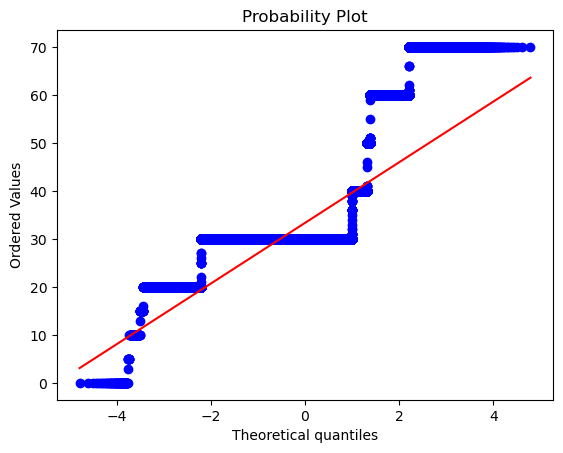

In [61]:
# Visual test for normality - Histogram/Boxplot/Q-Q plot for speed limit

# The data can be considered to have a non-uniform distribution from visual methods

# df_Ac_clean['Speed_limit'].hist(bins=30)
# df_Ac_clean['Speed_limit'].plot(kind='box')
stats.probplot(df_Ac_clean['Speed_limit'], dist="norm", plot=plt)
plt.show()

#### Bivariate analysis of Bikers dataset

In [62]:
# Contigency table for gender and accident severity
gender_severity_count_cross_table = count_cross_tabs(df_Bk_clean,'Gender','Severity') 
gender_severity_percent_cross_table = percent_cross_tabs(df_Bk_clean,'Gender','Severity')
gender_severity_percent_cross_table.round(2)

Severity,Fatal,Serious,Slight
Gender,,,
Female,0.71,16.01,83.28
Male,0.84,17.08,82.08
Other,0.00,2.52,97.48


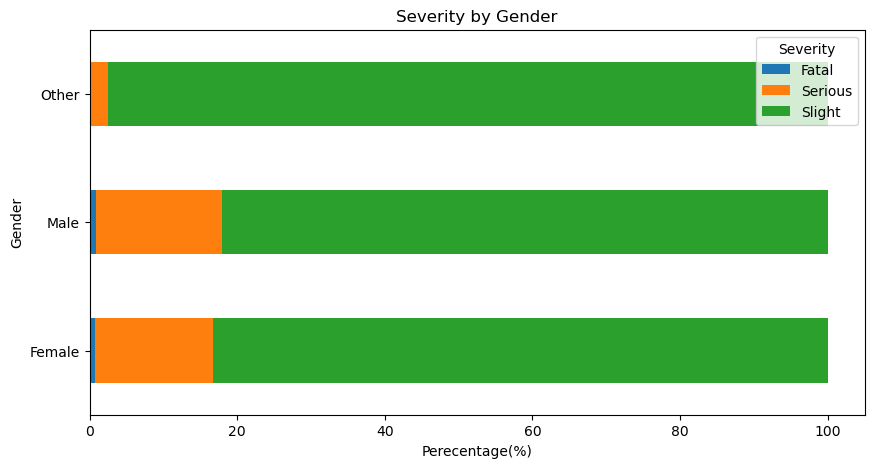

In [63]:
# Barchart for severity by gender
gender_severity_percent_cross_table.plot(kind='barh', stacked=True,xlabel='Perecentage(%)', 
                                         ylabel='Gender', title='Severity by Gender', layout='tight', figsize=(10,5))
plt.show()

In [64]:
# Contigency table for age group and accident severity
age_grp_severity_count_cross_table = count_cross_tabs(df_Bk_clean,'Age_Grp','Severity')
age_grp_severity_percent_cross_table = percent_cross_tabs(df_Bk_clean,'Age_Grp','Severity')
age_grp_severity_percent_cross_table.round(2)

Severity,Fatal,Serious,Slight
Age_Grp,,,
11 to 15,0.68,16.62,82.70
16 to 20,0.58,15.26,84.16
21 to 25,0.53,14.57,84.90
26 to 35,0.57,14.79,84.64
36 to 45,0.78,17.26,81.97
46 to 55,1.24,20.48,78.28
56 to 65,2.06,23.46,74.48
6 to 10,0.57,16.94,82.49
66 to 75,3.84,26.18,69.98


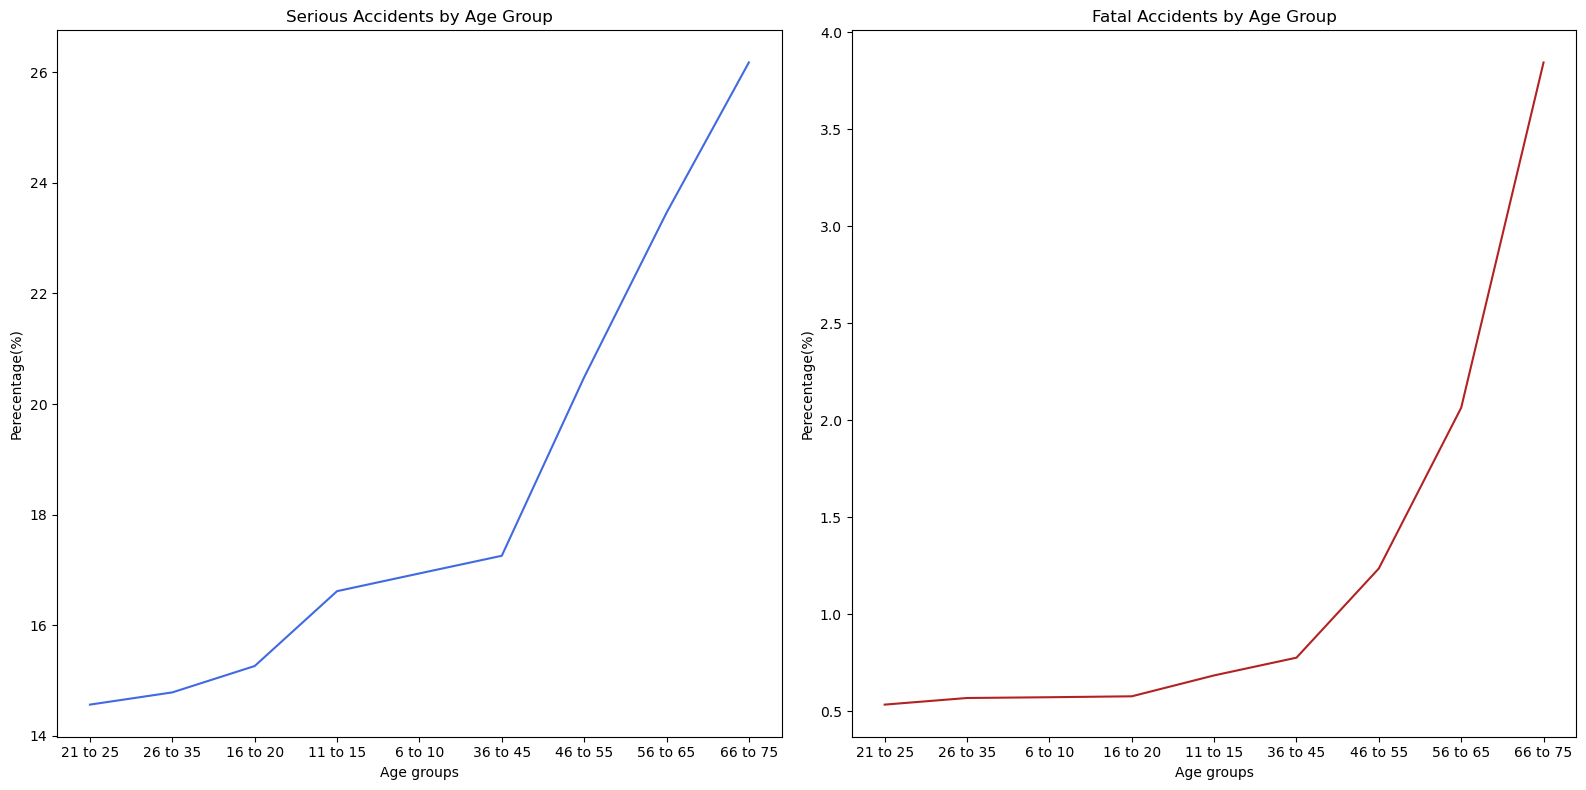

In [142]:
# Graph for Serious and Fatal accidents by age group
serious_sorted_table = age_grp_severity_percent_cross_table['Serious'].sort_values()
fatal_sorted_table = age_grp_severity_percent_cross_table['Fatal'].sort_values()

fig1,(ax1, ax2) = plt.subplots(1,2, figsize=(16,8), layout='tight')
ax1.plot(serious_sorted_table, color='royalblue')
ax1.set_title('Serious Accidents by Age Group')
ax1.set_ylabel('Perecentage(%)')
ax1.set_xlabel('Age groups')

ax2.plot(fatal_sorted_table, color='firebrick')
ax2.set_title('Fatal Accidents by Age Group')
ax2.set_ylabel('Perecentage(%)')
ax2.set_xlabel('Age groups')

plt.show()

In [67]:
# Contigency table for age group and gender 
gender_age_group_count_cross_table = count_cross_tabs(df_Bk_clean,'Age_Grp','Gender')
gender_age_group_percent_cross_table = percent_cross_tabs(df_Bk_clean,'Age_Grp','Gender')
gender_age_group_percent_cross_table.round(2)

Gender,Female,Male,Other
Age_Grp,,,
11 to 15,15.19,84.79,0.02
16 to 20,18.48,81.50,0.02
21 to 25,25.67,74.32,0.01
26 to 35,22.54,77.45,0.01
36 to 45,20.78,79.21,0.01
46 to 55,23.54,76.45,0.01
56 to 65,24.16,75.82,0.01
6 to 10,17.27,82.68,0.04
66 to 75,21.50,78.48,0.02


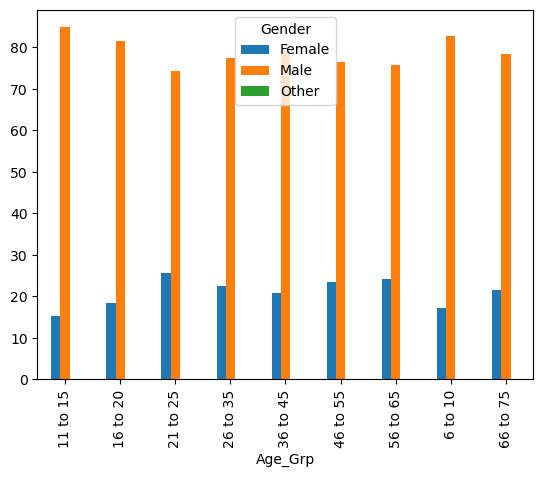

In [68]:
# Barchart for age group and gender
gender_age_group_percent_cross_table.plot(kind='bar')
plt.show()

#### Bivariate analysis for Accidents dataset

In [69]:
# Casualty statistics by day of the week
casualties_by_day = stats_groupby(df_Ac_clean,'Day','Number_of_Casualties')
casualties_by_day

,median,mean,count,sum,percentage
Day,,,,,
Sunday,1.0,1.068876,72841,77858,8.798699
Saturday,1.0,1.055812,87652,92544,10.587768
Monday,1.0,1.045305,125749,131446,15.189627
Friday,1.0,1.043630,132066,137828,15.952678
Thursday,1.0,1.044091,136263,142271,16.459647
Tuesday,1.0,1.043059,136534,142413,16.492382
Wednesday,1.0,1.042631,136756,142586,16.519198


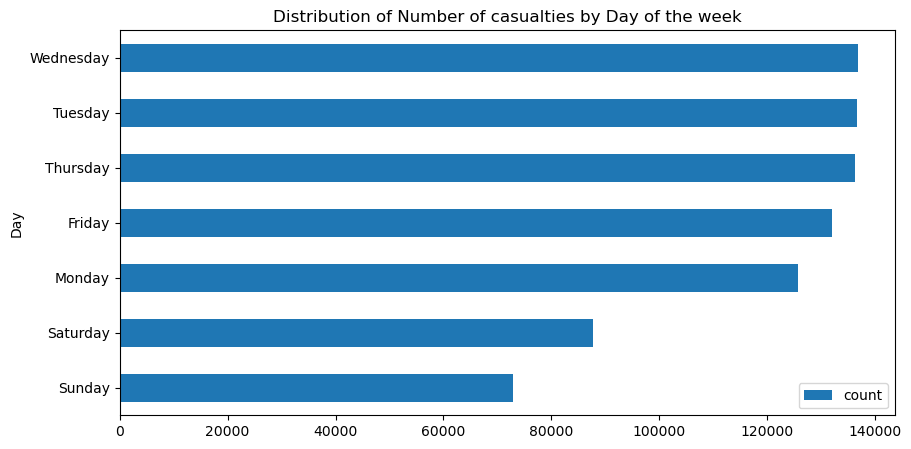

In [70]:
# Barchart of Casualty statistics by day of the week
casualties_by_day.plot(kind='barh', y='count', figsize=(10,5), title='Distribution of Number of casualties by Day of the week')
plt.show()

In [71]:
# Casualty statistics by road conditions
casualties_by_road_conditions = stats_groupby(df_Ac_clean,'Road_conditions','Number_of_Casualties')
casualties_by_road_conditions

,median,mean,count,sum,percentage
Road_conditions,,,,,
Flood,1.0,1.063433,268,285,0.032373
Missing Data,1.0,1.029733,1648,1697,0.199067
Snow,1.0,1.029825,1710,1761,0.206556
Frost,1.0,1.044684,6020,6289,0.727175
Wet,1.0,1.042305,184279,192075,22.259655
Dry,1.0,1.048748,633936,664839,76.575174


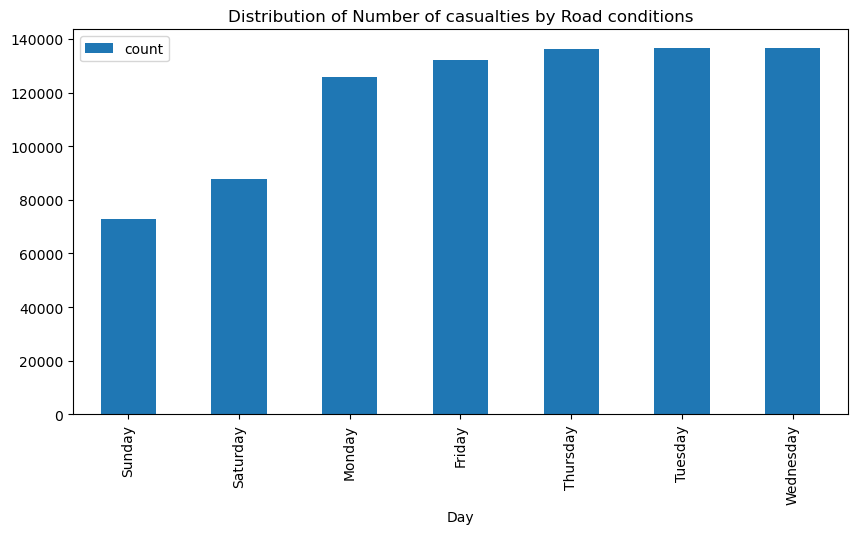

In [72]:
# Barchart of Casualty statistics by road conditions
casualties_by_day.plot(kind='bar', y='count', figsize=(10,5), title='Distribution of Number of casualties by Road conditions')
plt.show()

In [73]:
# Casualty statistics by weather conditions
casualties_by_weather_conditions = stats_groupby(df_Ac_clean,'Weather_conditions','Number_of_Casualties')
casualties_by_weather_conditions

,median,mean,count,sum,percentage
Weather_conditions,,,,,
Snow and windy,1.0,1.031056,483,498,0.058343
Snow,1.0,1.034995,2086,2159,0.251975
Fog,1.0,1.032651,3369,3479,0.406952
Rain and windy,1.0,1.034741,8808,9114,1.063947
Other,1.0,1.022673,11820,12088,1.427776
Clear and windy,1.0,1.045076,11891,12427,1.436352
Unknown,1.0,1.045389,24235,25335,2.927424
Rain,1.0,1.038802,82007,85189,9.905890
Clear,1.0,1.049029,683162,716657,82.521341


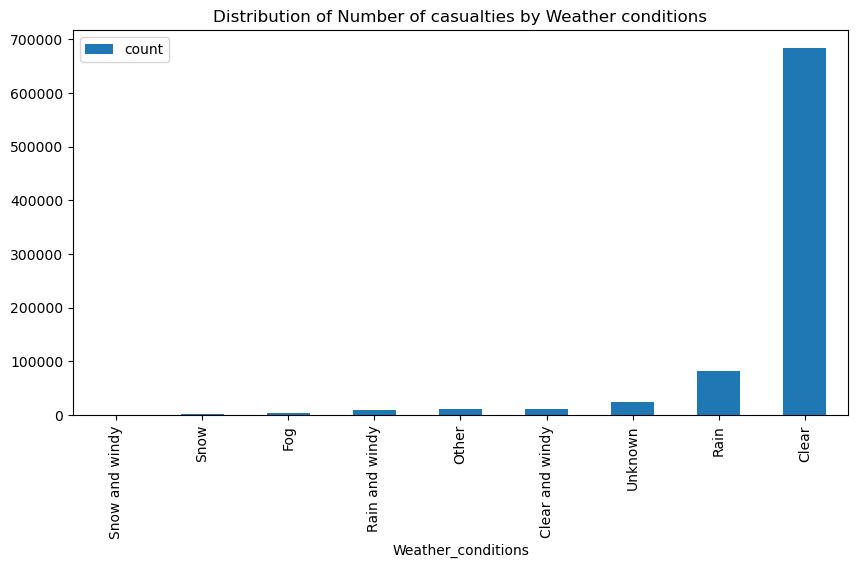

In [74]:
# Barchart of Casualty statistics by weather conditions
casualties_by_weather_conditions.plot(kind='bar', y='count', figsize=(10,5), title='Distribution of Number of casualties by Weather conditions')
plt.show()

In [75]:
# Casualty statistics by road type
casualties_by_road_type = stats_groupby(df_Ac_clean,'Road_type','Number_of_Casualties')
casualties_by_road_type

,median,mean,count,sum,percentage
Road_type,,,,,
Slip road,1.0,1.034279,846,875,0.102191
One way street,1.0,1.034880,5562,5756,0.671852
Unknown,1.0,1.042941,30647,31963,3.701950
Dual carriageway,1.0,1.055033,59037,62286,7.131270
Roundabout,1.0,1.018317,75066,76441,9.067464
Single carriageway,1.0,1.050132,656703,689625,79.325273


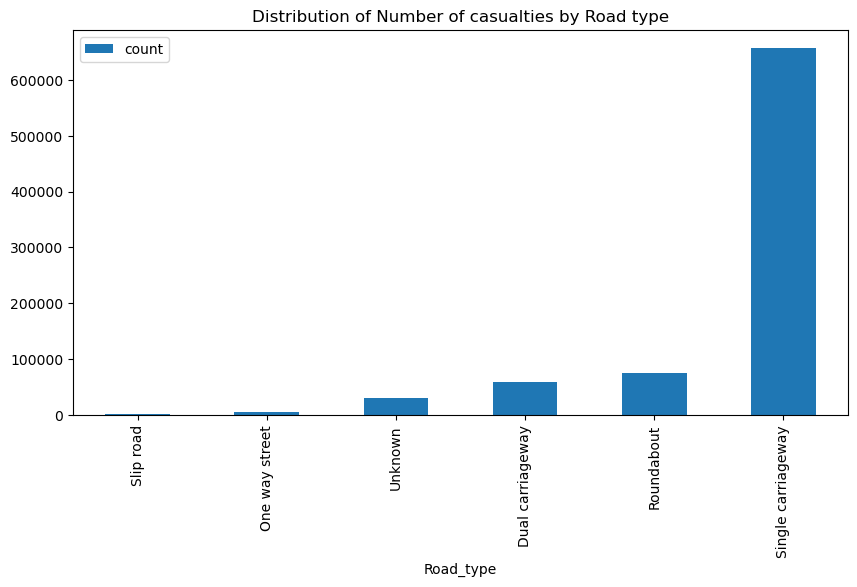

In [76]:
# Barchart of Casualty statistics by road type
casualties_by_road_type.plot(kind='bar', y='count', figsize=(10,5), title='Distribution of Number of casualties by Road type')
plt.show()

In [77]:
# Casualty statistics by light conditions
casualties_by_light_conditions = stats_groupby(df_Ac_clean,'Light_conditions','Number_of_Casualties')
casualties_by_light_conditions

,median,mean,count,sum,percentage
Light_conditions,,,,,
Darkness no lights,1.0,1.065249,25165,26807,3.039762
Darkness lights lit,1.0,1.039531,142039,147654,17.157349
Daylight,1.0,1.048176,660657,692485,79.802890


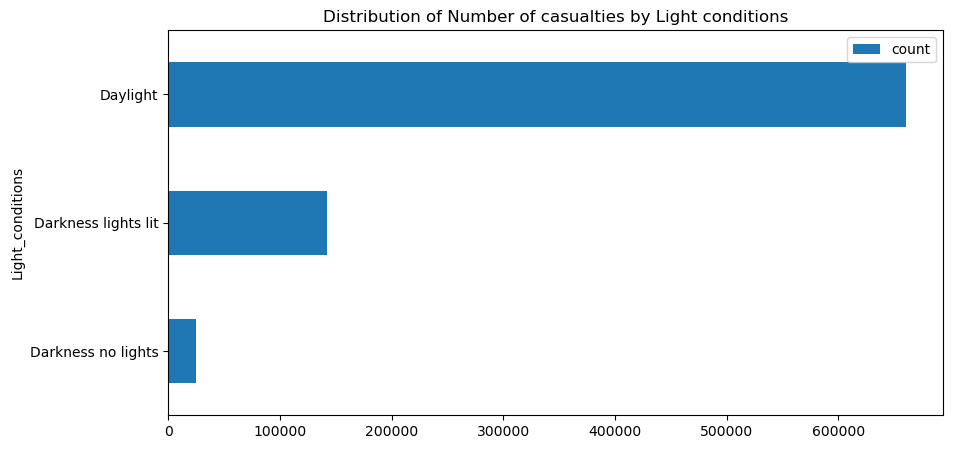

In [78]:
# Barchart of Casualty statistics by light conditions
casualties_by_light_conditions.plot(kind='barh', y='count', figsize=(10,5), title='Distribution of Number of casualties by Light conditions')
plt.show()

In [79]:
# Casualty statistics by gender
casualties_by_gender = stats_groupby(df_Ac_Bk_clean,'Gender','Number_of_Casualties')
casualties_by_gender

,median,mean,count,sum,percentage
Gender,,,,,
Other,1.0,1.042017,119,124,0.014374
Female,1.0,1.044694,167717,175213,20.259077
Male,1.0,1.047853,660025,691609,79.726548


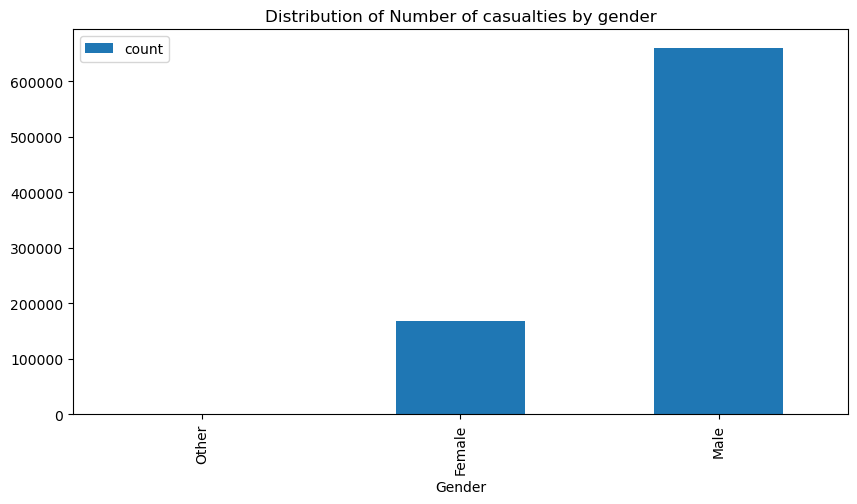

In [80]:
# Barchart of Casualty statistics by gender
casualties_by_gender.plot(kind='bar', y='count', figsize=(10,5), title='Distribution of Number of casualties by gender')
plt.show()

In [81]:
# Casualty statistics by age group
casualties_by_age_grp = stats_groupby(df_Ac_Bk_clean,'Age_Grp','Number_of_Casualties')
casualties_by_age_grp

,median,mean,count,sum,percentage
Age_Grp,,,,,
66 to 75,1.0,1.050054,15663,16447,1.891984
56 to 65,1.0,1.043924,41913,43754,5.062806
6 to 10,1.0,1.045559,68021,71120,8.216476
46 to 55,1.0,1.041739,73577,76648,8.887603
21 to 25,1.0,1.041058,87291,90875,10.544161
36 to 45,1.0,1.040367,103773,107962,12.535075
16 to 20,1.0,1.050994,122602,128854,14.809491
26 to 35,1.0,1.038979,145078,150733,17.524439
11 to 15,1.0,1.062433,169943,180553,20.527963


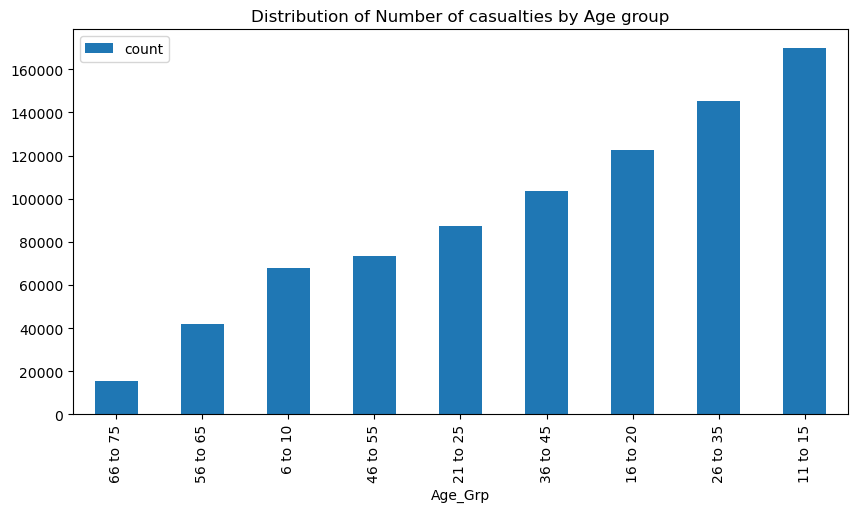

In [82]:
# Barchart of Casualty statistics by gender
casualties_by_age_grp.plot(kind='bar', y='count', figsize=(10,5), title='Distribution of Number of casualties by Age group')
plt.show()

In [83]:
# Casualty burdern light condition and road type 
casualties_by_road_type_light_conditions = pd.DataFrame(df_Ac_clean.groupby(['Road_type','Light_conditions'], as_index=False)['Number_of_Casualties'].sum())
casualties_by_road_type_light_conditions

,Road_type,Light_conditions,Number_of_Casualties
0,Dual carriageway,Darkness lights lit,11359
1,Dual carriageway,Darkness no lights,2319
2,Dual carriageway,Daylight,48608
3,One way street,Darkness lights lit,1111
4,One way street,Darkness no lights,95
5,One way street,Daylight,4550
6,Roundabout,Darkness lights lit,19057
7,Roundabout,Darkness no lights,1807
8,Roundabout,Daylight,55577
9,Single carriageway,Darkness lights lit,111214


In [84]:
# Casualty burdern weather condition and road type
casualties_by_road_type_weather_conditions = pd.DataFrame(df_Ac_clean.groupby(['Road_type','Weather_conditions'], as_index=False)['Number_of_Casualties'].sum())
casualties_by_road_type_weather_conditions

,Road_type,Weather_conditions,Number_of_Casualties
0,Dual carriageway,Clear,51436
1,Dual carriageway,Clear and windy,1138
2,Dual carriageway,Fog,239
3,Dual carriageway,Other,781
4,Dual carriageway,Rain,6121
5,Dual carriageway,Rain and windy,740
6,Dual carriageway,Snow,150
7,Dual carriageway,Snow and windy,37
8,Dual carriageway,Unknown,1644
9,One way street,Clear,4976


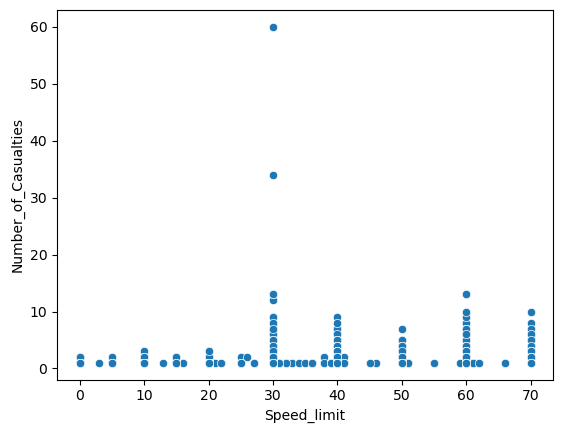

In [85]:
# Scatterplot of Speed limit and number of casualties
sns.scatterplot(data = df_Ac_clean, x= df_Ac_clean["Speed_limit"], y= df_Ac_clean['Number_of_Casualties'])
plt.show()

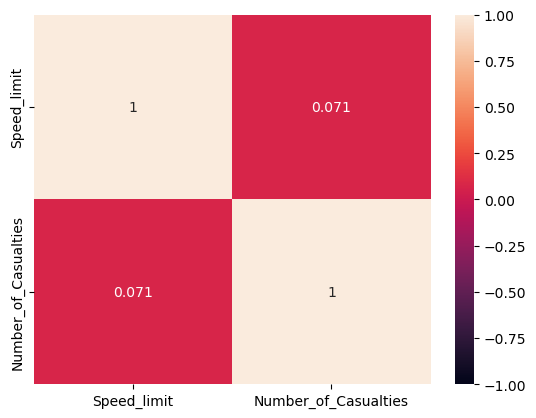

In [86]:
df_Ac_clean_corr = df_Ac_clean[["Speed_limit",'Number_of_Casualties']].corr()
heatmap = sns.heatmap(df_Ac_clean_corr, vmin=-1, vmax=1, annot=True)
plt.show()

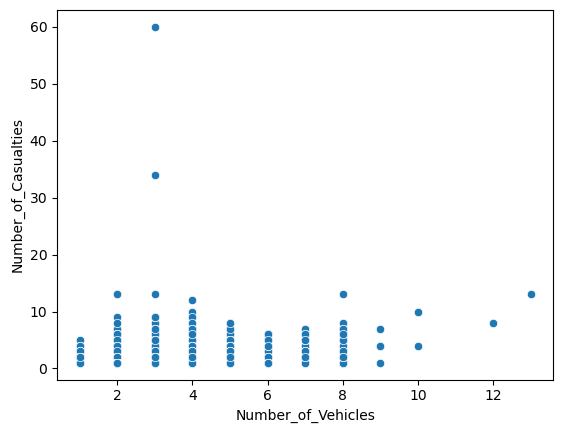

In [87]:
# Scatterplot of number of vehicles and number of casualties
sns.scatterplot(data = df_Ac_clean, x= df_Ac_clean["Number_of_Vehicles"], y= df_Ac_clean['Number_of_Casualties'])
plt.show()

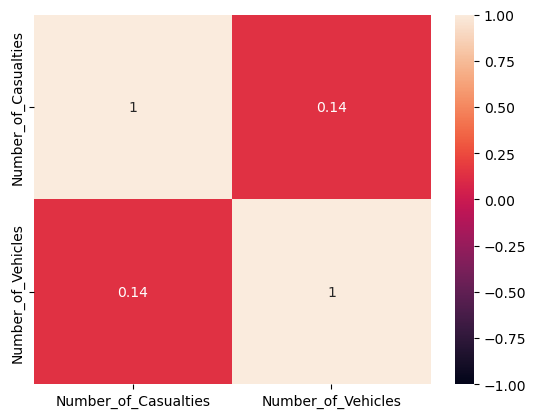

In [88]:
df_Ac_clean_corr = df_Ac_clean[["Number_of_Casualties",'Number_of_Vehicles']].corr()
heatmap = sns.heatmap(df_Ac_clean_corr, vmin=-1, vmax=1, annot=True)
plt.show()

#### Time Series Analysis

In [89]:
# Casualties per year and month

# set index of dataframe to Date
df_Ac_time_series = change_index(df_Ac_clean,'Date',False)

casualties_per_year = pd.DataFrame(df_Ac_time_series.resample('YE')["Number_of_Casualties"].sum())
casualties_per_month = pd.DataFrame(df_Ac_time_series.resample('ME')["Number_of_Casualties"].sum())

In [90]:
# # Create a complete date range for comparison
# expected_range_year = pd.date_range(start=1979, end=2018, freq='YE')
# expected_range_month = pd.date_range(start=1979, end=2018, freq='ME')
# expected_range_day = pd.date_range(start=1979, end=2018, freq='D')

# # Find missing dates
# missing_dates_months = expected_range_month.difference(casualties_per_month.index)
# missing_dates_year = expected_range_year.difference(casualties_per_year.index)
# missing_dates_day = expected_range_day.difference(casualties_per_day.index)
# print(f"Missing months: {len(missing_dates_months)}")
# print(f"Missing years: {len(missing_dates_year)}")
# print(f"Missing day: {len(missing_dates_day)}")
# missing_dates_day

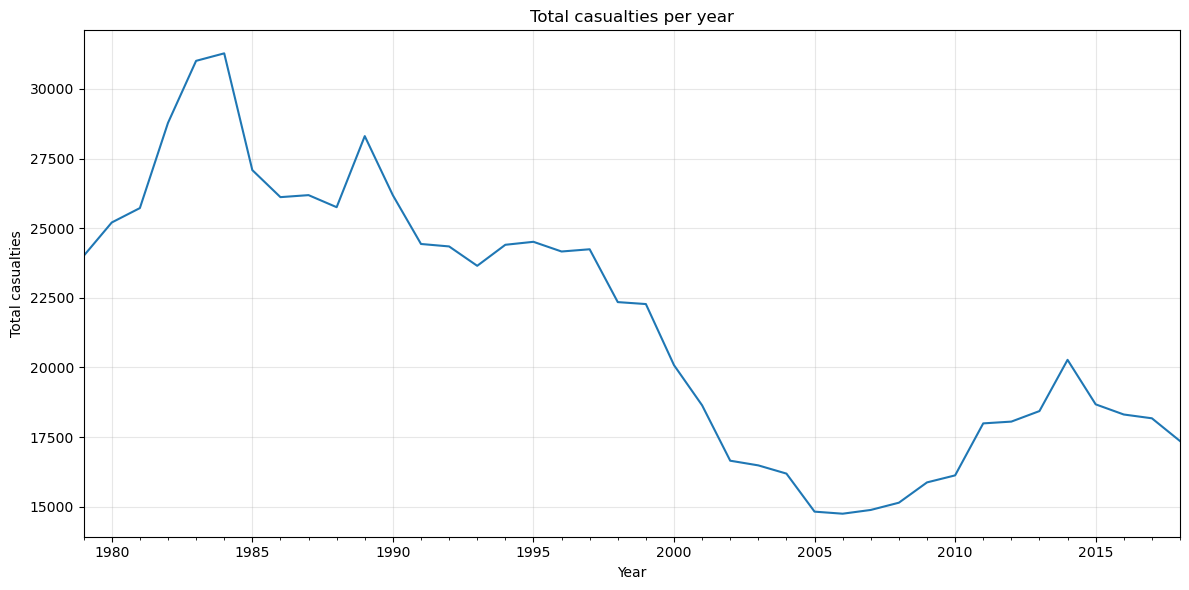

In [91]:
# Line graph of casualties per year(1979 - 2018)
casualties_per_year['Number_of_Casualties'].plot(
    xlabel="Year", 
    ylabel="Total casualties", 
    title="Total casualties per year", 
    figsize=(12,6))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

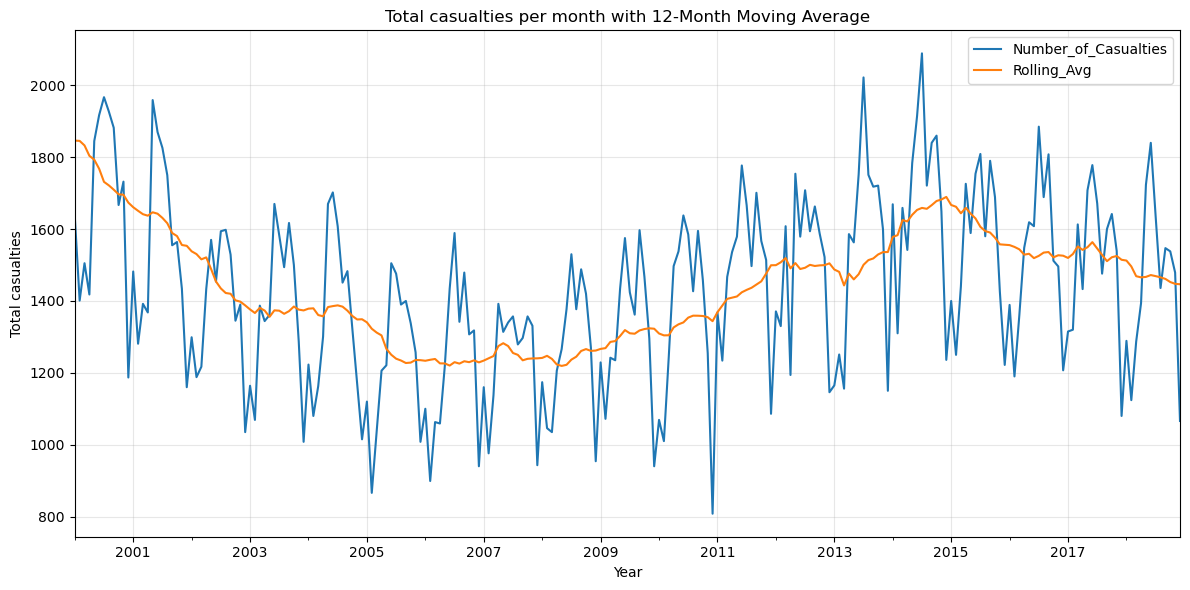

In [92]:
# Smoothing: Line graph of casualties per month with rolling average (1979 - 2018)
casualties_per_month['Rolling_Avg'] = casualties_per_month['Number_of_Casualties'].rolling(window=12).mean()
recent_data = casualties_per_month['2000':]
recent_data[['Number_of_Casualties','Rolling_Avg']].plot(
    xlabel="Year", 
    ylabel="Total casualties", 
    title="Total casualties per month with 12-Month Moving Average", 
    figsize=(12,6))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Forcasting out of the scope of this analysis

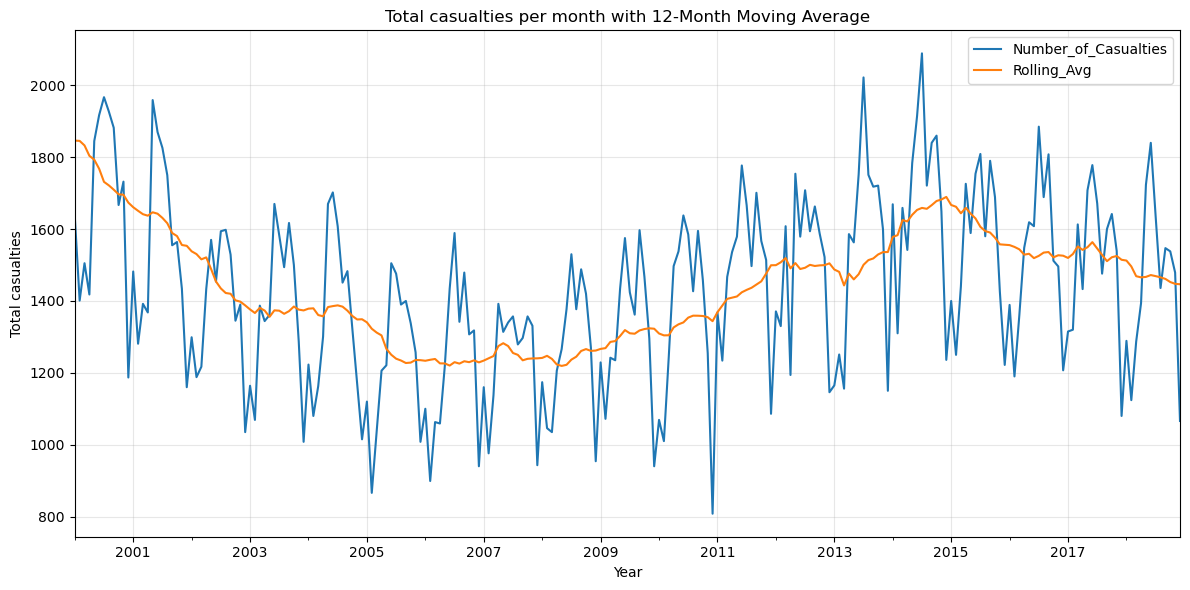

In [93]:
# Smoothing: Line graph of casualties per month with rolling average (2000 - 2018)
casualties_per_month['Rolling_Avg'] = casualties_per_month['Number_of_Casualties'].rolling(window=12).mean()
recent_data = casualties_per_month['2000':]
recent_data[['Number_of_Casualties','Rolling_Avg']].plot(
    xlabel="Year", 
    ylabel="Total casualties", 
    title="Total casualties per month with 12-Month Moving Average", 
    figsize=(12,6))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Forcasting out of the scope of this analysis

In [94]:
# Smoothing: Exponential smoothing with Holt-Winters
exponentialmodel = ExponentialSmoothing(casualties_per_month['Number_of_Casualties'])
fit = exponentialmodel.fit(smoothing_level=0.7)
fitted_values = fit.fittedvalues
casualties_per_month['Exp_Smthn'] = fitted_values

# Forcasting out of the scope of this analysis

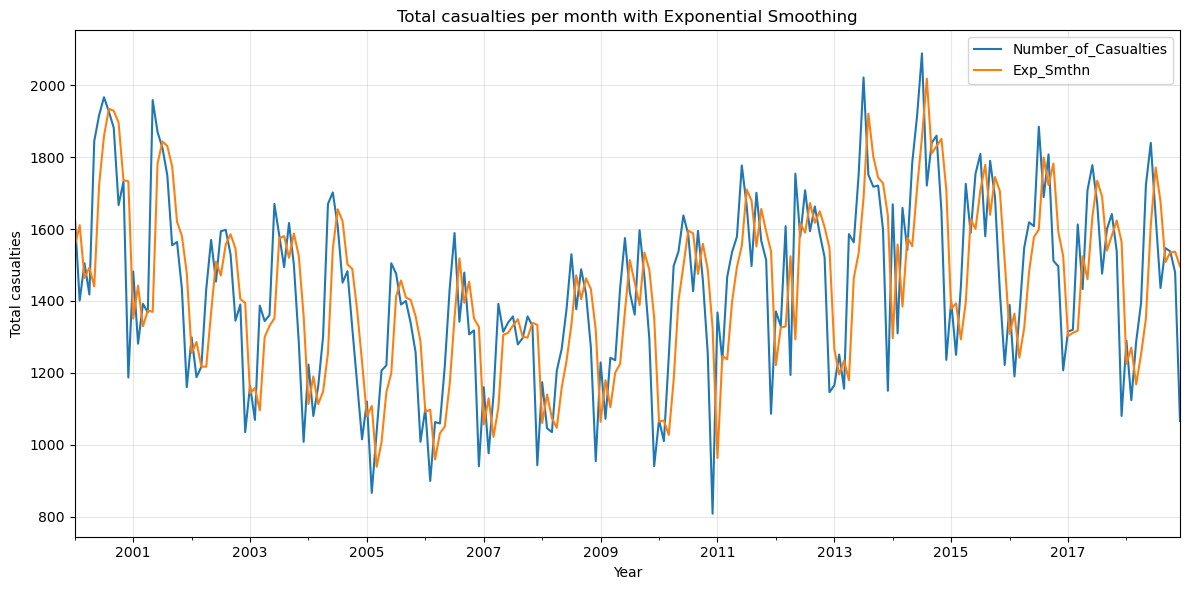

In [95]:
# Smoothing: Line graph of casualties per month with exponential smoothing (2000 - 2018)
recent_data = casualties_per_month['2000-01-31':]
recent_data[['Number_of_Casualties','Exp_Smthn']].plot(
    xlabel="Year", 
    ylabel="Total casualties", 
    title="Total casualties per month with Exponential Smoothing", 
    figsize=(12,6))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Forcasting out of the scope of this analysis

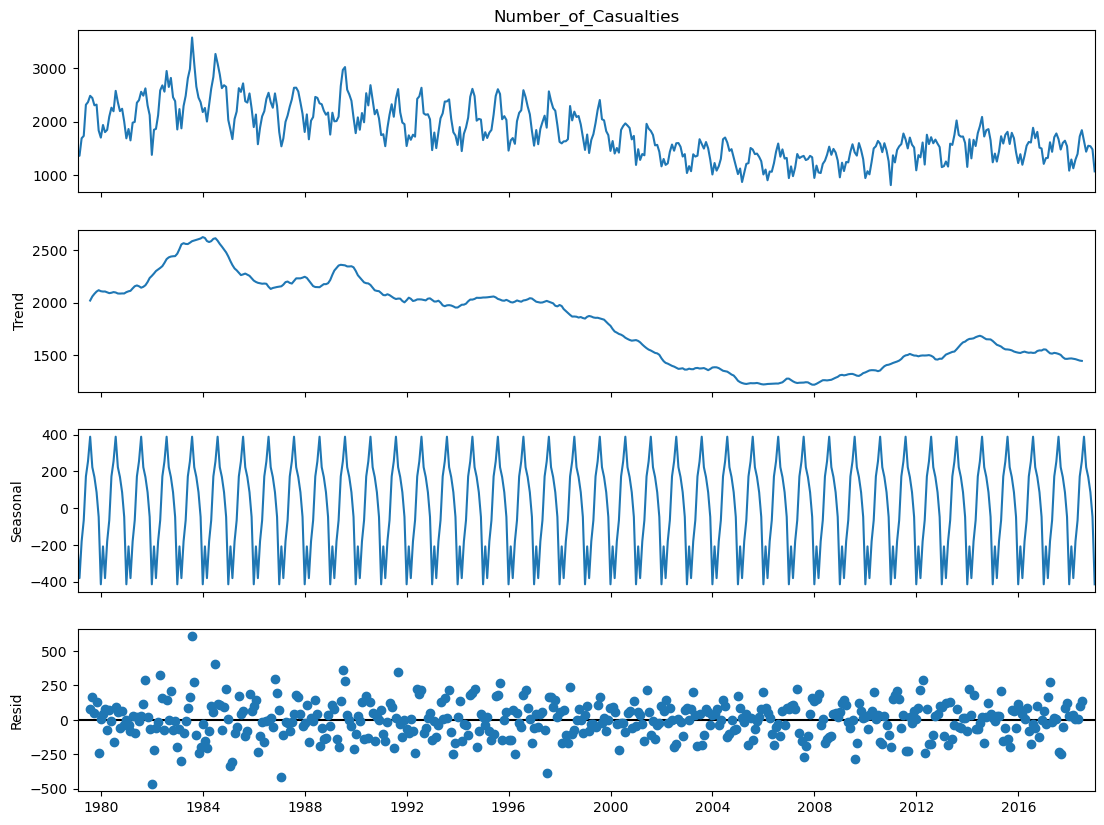

In [96]:
# Decomposition: Number of casualties with seasonal decompose
seasonal_decomp_result = seasonal_decompose(casualties_per_month["Number_of_Casualties"], model='additive', period = 12)
fig = seasonal_decomp_result.plot()
fig.set_size_inches((12, 9))
plt.show()

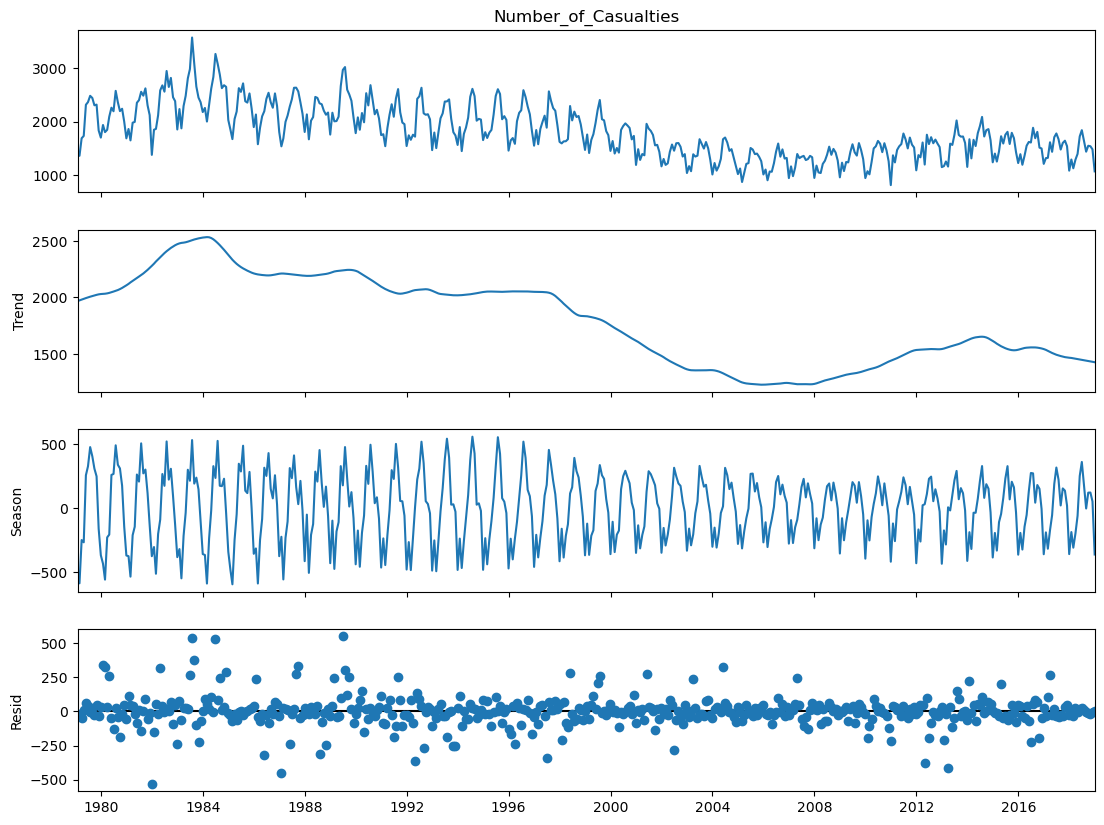

In [97]:
# Decomposition: Number of casualties with STL (Seasonal and Trend decomposition using Loess) 
stl_decomp_result = STL(casualties_per_month["Number_of_Casualties"], period = 12, robust=True)
stl_decomp_result = stl_decomp_result.fit()
fig = stl_decomp_result.plot()
fig.set_size_inches((12, 9))
plt.show()

In [98]:
# Decomposition: Extract individual trends
snl_trend = seasonal_decomp_result.trend
snl_seasonal = seasonal_decomp_result.seasonal
snl_residual = seasonal_decomp_result.resid

stl_trend = stl_decomp_result.trend
stl_seasonal = stl_decomp_result.seasonal
stl_residual = stl_decomp_result.resid

In [99]:
# Seasonal Analysis: Get highest and lowest month from seasonal data
# STL selected because it is more robust

stl_peak_month = stl_seasonal.idxmax()
stl_low_month = stl_seasonal.idxmin()
print(f"STL Highest risk month: {stl_peak_month.month_name()}")
print(f"STL Lowest risk month: {stl_low_month.month_name()}")

snl_peak_month = snl_seasonal.idxmax()
snl_low_month = snl_seasonal.idxmin()
print(f"SNL Highest risk month: {snl_peak_month.month_name()}")
print(f"SNL Lowest risk month: {snl_low_month.month_name()}")

STL Highest risk month: July
STL Lowest risk month: February
SNL Highest risk month: July
SNL Lowest risk month: December


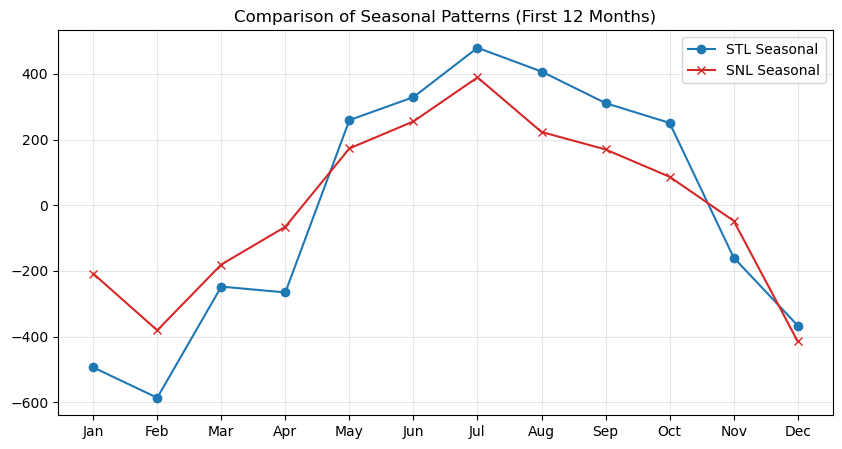

In [100]:
# Seasonal Analysis: Line graph of both SNL and STL seasonal decomposition 

snl_seasonal_pattern = snl_seasonal[:12]  # First year's pattern (repeats every year)
snl_seasonal_df = pd.DataFrame({
    'Month': range(1, 13),
    'Seasonal_Values': snl_seasonal_pattern.values
})

stl_seasonal_pattern = stl_seasonal[:12]  # First year's pattern (repeats every year)
stl_seasonal_df = pd.DataFrame({
    'Month': range(1, 13),
    'Seasonal_Values': stl_seasonal_pattern.values
})


plt.figure(figsize=(10, 5))
plt.plot(stl_seasonal_df['Seasonal_Values'], label='STL Seasonal', marker='o')
plt.plot(snl_seasonal_df['Seasonal_Values'], label='SNL Seasonal', marker='x', color='tab:red')
plt.title("Comparison of Seasonal Patterns (First 12 Months)")
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [101]:
# Seasonal Analysis: Calculate seasonal strength
seasonal_strength = 1 - (stl_residual.var() / (stl_residual + stl_seasonal).var())
print(f"Seasonal strength: {seasonal_strength:.2%}")

Seasonal strength: 83.76%


Found 9 outlier events


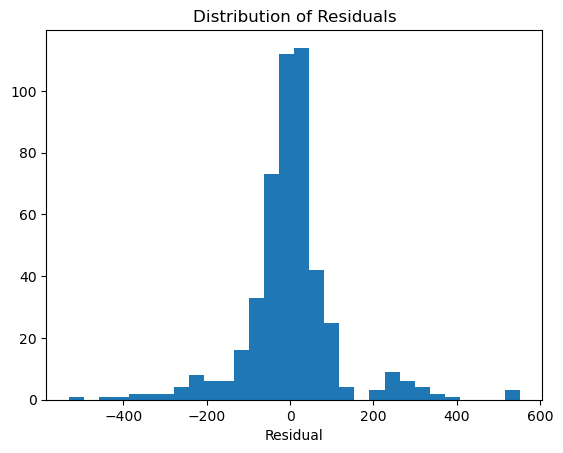

In [102]:
# Residual Analysis: Checking outliers using residuals
residual_std = stl_residual.std()
outliers = stl_residual[abs(stl_residual) > 3 * residual_std]
df_outliers = outliers.to_frame(name='residuals')
print(f"Found {len(outliers)} outlier events")

plt.hist(stl_residual, bins=30, )
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.show()

In [103]:
# Casualties per traffic status
casualties_per_traffic_status = stats_groupby(df_Ac_clean,'Traffic_status','Number_of_Casualties')
casualties_per_traffic_status

,median,mean,count,sum,percentage
Traffic_status,,,,,
Night/Dawn Off-Peak,1.0,1.049139,106698,111941,12.888396
Afternoon School Pickup,1.0,1.049707,142676,149768,17.234294
Morning Rush Hour,1.0,1.037985,166617,172946,20.126205
Day Off-Peak,1.0,1.051230,197129,207228,23.811848
Evening Rush Hour,1.0,1.048067,214741,225063,25.939258


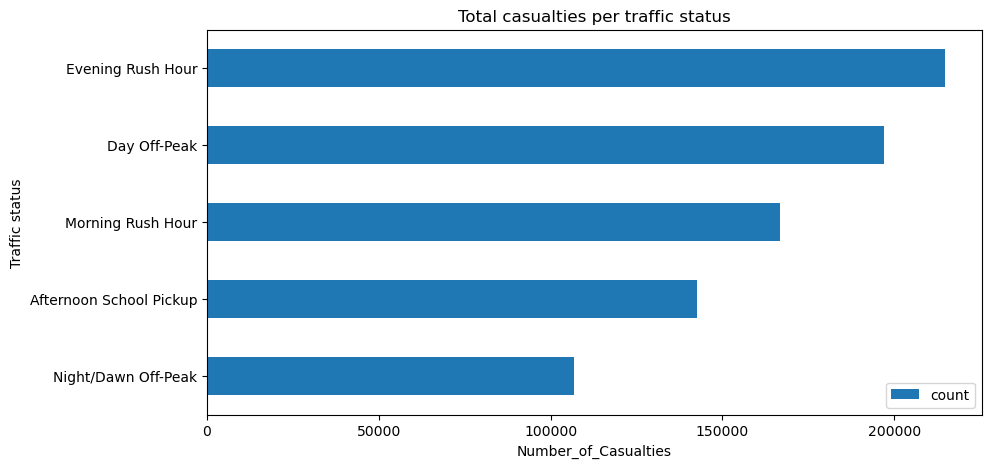

In [104]:
# Bar chart of Casualties per traffic status
casualties_per_traffic_status.plot(kind='barh',y='count', figsize=(10,5), xlabel="Number_of_Casualties", ylabel="Traffic status", title="Total casualties per traffic status")
plt.show()

### Inferential Statistics

In [105]:
# Test if a relationship exists between road conditions and number of casualties

# Road_conditions[Nominal] x Number of casualties[Ratio - Not Uniformly Distributed]
# Therefore Kruskal–Wallis is suitable 
# Conditions 1. Nominal IV with several levels. 2. Non-normality DV. 3.Independent measures.
# --------------------------------------------------------------------------------------------------

run_kruskal_wallis(df_Ac_Bk_clean,'Road_conditions','Number_of_Casualties')

# KruskalResult(statistic=np.float64(161.7817388834576), pvalue=np.float64(4.128411472930475e-33))

{'H_stat': np.float64(161.7817388834576),
 'p_val': np.float64(4.128411472930475e-33),
 'comment': 'The relationship/difference may be significant',
 'dunn_posthoc':                        Dry     Flood     Frost  Missing Data      Snow  \
 Dry           1.000000e+00  1.000000  0.027076      0.000248  0.004660   
 Flood         1.000000e+00  1.000000  1.000000      0.359493  0.723336   
 Frost         2.707607e-02  1.000000  1.000000      0.268149  1.000000   
 Missing Data  2.475645e-04  0.359493  0.268149      1.000000  1.000000   
 Snow          4.659722e-03  0.723336  1.000000      1.000000  1.000000   
 Wet           2.572086e-28  1.000000  1.000000      0.030236  0.269664   
 
                        Wet  
 Dry           2.572086e-28  
 Flood         1.000000e+00  
 Frost         1.000000e+00  
 Missing Data  3.023608e-02  
 Snow          2.696642e-01  
 Wet           1.000000e+00  ,
 'epsilon_sq': np.float64(0.00019542161583293986)}

In [106]:
# Test if a relationship exists between road type and number of casualties

# Road_type[Nominal] x Number of casualties[Ratio - Not Uniformly Distributed]
# Therefore Kruskal–Wallis is suitable 
# Conditions 1. Nominal IV with several levels. 2. Non-normality DV. 3.Independent measures.
# --------------------------------------------------------------------------------------------------

run_kruskal_wallis(df_Ac_Bk_clean,'Road_type','Number_of_Casualties')

# KruskalResult(statistic=np.float64(1339.4839671774698), pvalue=np.float64(1.782172044150907e-287))

{'H_stat': np.float64(1339.4839671774698),
 'p_val': np.float64(1.782172044150907e-287),
 'comment': 'The relationship/difference may be significant',
 'dunn_posthoc':                     Dual carriageway  One way street     Roundabout  \
 Dual carriageway        1.000000e+00    5.783997e-08  8.686237e-177   
 One way street          5.783997e-08    1.000000e+00   1.605594e-06   
 Roundabout             8.686237e-177    1.605594e-06   1.000000e+00   
 Single carriageway      4.986884e-05    4.933878e-05  1.027187e-273   
 Slip road               2.150266e-01    1.000000e+00   5.723741e-01   
 Unknown                 4.604045e-09    1.290050e-01   2.658687e-60   
 
                     Single carriageway  Slip road       Unknown  
 Dual carriageway          4.986884e-05   0.215027  4.604045e-09  
 One way street            4.933878e-05   1.000000  1.290050e-01  
 Roundabout               1.027187e-273   0.572374  2.658687e-60  
 Single carriageway        1.000000e+00   0.893595  4.65969

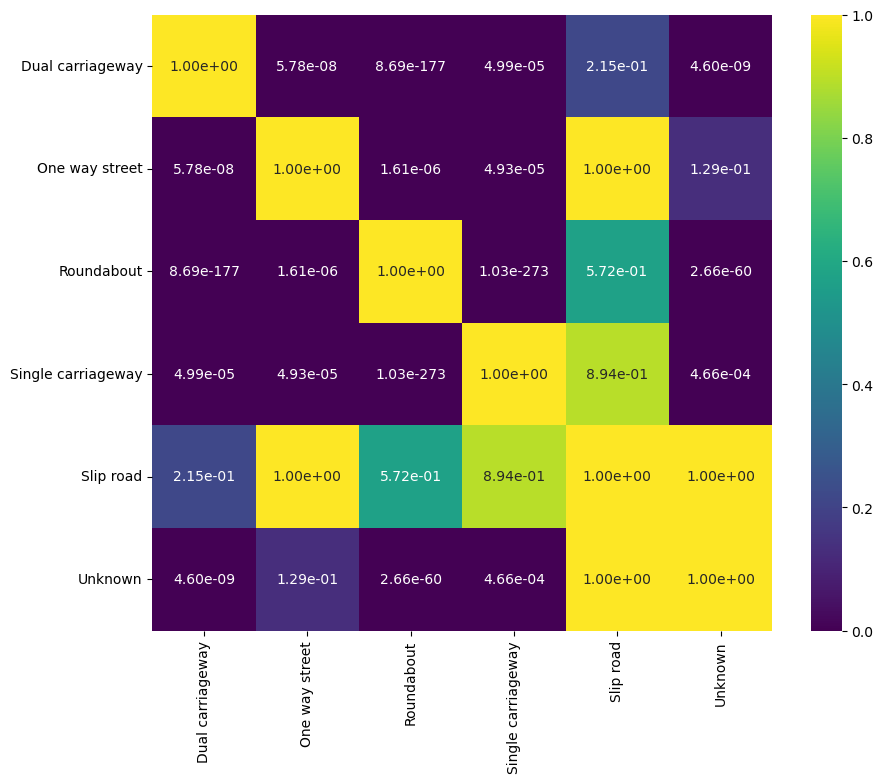

In [107]:
# Visualisation of matrix

dunn_result = run_dunn_test(df_Ac_Bk_clean,'Road_type','Number_of_Casualties')
dunn_result

plt.figure(figsize=(10, 8))
sns.heatmap(dunn_result, annot=True, cmap='viridis', fmt=".2e")
plt.show()

In [108]:
# Test if a relationship exists between weather condition and number of casualties

# weather_condition[Nominal] x Number of casualties[Ratio - Not Uniformly Distributed]
# Therefore Kruskal–Wallis is suitable 
# Conditions 1. Nominal IV with several levels. 2. Non-normality DV. 3.Independent measures.
# --------------------------------------------------------------------------------------------------

run_kruskal_wallis(df_Ac_Bk_clean,'Weather_conditions','Number_of_Casualties')

# KruskalResult(statistic=np.float64(333.93931612338326), pvalue=np.float64(2.418724937241877e-67))

{'H_stat': np.float64(333.93931612338326),
 'p_val': np.float64(2.418724937241877e-67),
 'comment': 'The relationship/difference may be significant',
 'dunn_posthoc':                         Clear  Clear and windy       Fog         Other  \
 Clear            1.000000e+00     1.000000e+00  0.000916  6.767238e-33   
 Clear and windy  1.000000e+00     1.000000e+00  0.035284  2.024603e-14   
 Fog              9.164853e-04     3.528385e-02  1.000000  1.000000e+00   
 Other            6.767238e-33     2.024603e-14  1.000000  1.000000e+00   
 Rain             1.620576e-31     9.190204e-03  1.000000  6.808767e-11   
 Rain and windy   8.526416e-08     2.728696e-03  1.000000  1.557776e-02   
 Snow             9.139580e-02     5.359767e-01  1.000000  1.000000e+00   
 Snow and windy   1.000000e+00     1.000000e+00  1.000000  1.000000e+00   
 Unknown          1.000000e+00     1.000000e+00  0.031735  3.535973e-18   
 
                          Rain  Rain and windy      Snow  Snow and windy  \
 Clear

In [109]:
# Test if a relationship exists between Light conditions and number of casualties

# Light conditions[Nominal] x Number of casualties[Ratio - Not Uniformly Distributed]
# Therefore Kruskal–Wallis is suitable 
# Conditions 1. Nominal IV with several levels. 2. Non-normality DV. 3.Independent measures.
# --------------------------------------------------------------------------------------------------

run_kruskal_wallis(df_Ac_Bk_clean,'Light_conditions','Number_of_Casualties')

# KruskalResult(statistic=np.float64(272.4180174400154), pvalue=np.float64(7.001307096078676e-60))

{'H_stat': np.float64(272.4180174400154),
 'p_val': np.float64(7.001307096078676e-60),
 'comment': 'The relationship/difference may be significant',
 'dunn_posthoc':                      Darkness lights lit  Darkness no lights      Daylight
 Darkness lights lit         1.000000e+00        3.911370e-47  2.525862e-35
 Darkness no lights          3.911370e-47        1.000000e+00  5.662789e-22
 Daylight                    2.525862e-35        5.662789e-22  1.000000e+00,
 'epsilon_sq': np.float64(0.0003290629060952521)}

In [110]:
# Test if a relationship exists between age group and number of casualties

# age_type[ordinal] x Number of casualties[Ratio - Not Uniformly Distributed]
# Therefore Kruskal–Wallis is suitable 
# Conditions 1. Ordinal IV with several levels. 2. Non-normality DV. 3.Independent measures.
# --------------------------------------------------------------------------------------------------

run_kruskal_wallis(df_Ac_Bk_clean,'Age_Grp','Number_of_Casualties')

# KruskalResult(statistic=np.float64(1287.2840214784853), pvalue=np.float64(1.3171466054277861e-272))

{'H_stat': np.float64(1287.2840214784853),
 'p_val': np.float64(1.3171466054277861e-272),
 'comment': 'The relationship/difference may be significant',
 'dunn_posthoc':                11 to 15      16 to 20       21 to 25       26 to 35  \
 11 to 15   1.000000e+00  4.497209e-43  3.326395e-119  1.749205e-189   
 16 to 20   4.497209e-43  1.000000e+00   1.743070e-22   9.869030e-41   
 21 to 25  3.326395e-119  1.743070e-22   1.000000e+00   1.000000e+00   
 26 to 35  1.749205e-189  9.869030e-41   1.000000e+00   1.000000e+00   
 36 to 45  4.771661e-148  5.418547e-31   1.000000e+00   1.000000e+00   
 46 to 55  6.117430e-103  6.008870e-19   1.000000e+00   1.000000e+00   
 56 to 65   7.908368e-53  4.672656e-07   1.000000e+00   6.856210e-03   
 6 to 10    5.789634e-53  5.843720e-03   6.060534e-06   2.361431e-12   
 66 to 75   2.674322e-10  1.000000e+00   1.365644e-04   3.617516e-07   
 
                36 to 45       46 to 55      56 to 65       6 to 10  \
 11 to 15  4.771661e-148  6.117430e-103

In [111]:
# Test if a relationship exists between gender and number of casualties

# Gender[Nominal] x Number of casualties[Ratio - Not Uniformly Distributed]
# Therefore Kruskal-Wallis is suitable
# Conditions 1. Nominal IV with 3 levels. 2. Non-normality DV. 3.Independent measures.
# --------------------------------------------------------------------------------------------------

run_kruskal_wallis(df_Ac_Bk_clean,'Gender','Number_of_Casualties')

# KruskalResult(statistic=np.float64(24.72630678580953), pvalue=np.float64(4.273175232476011e-06))

{'H_stat': np.float64(24.72630678580953),
 'p_val': np.float64(4.273175232476011e-06),
 'comment': 'The relationship/difference may be significant',
 'dunn_posthoc':           Female      Male  Other
 Female  1.000000  0.000002    1.0
 Male    0.000002  1.000000    1.0
 Other   1.000000  1.000000    1.0,
 'epsilon_sq': np.float64(2.9867739455716582e-05)}

In [112]:
# Test if a relationship exists between traffic status(time of the day) and number of casualties

# Traffic_status[Ordinal] x Number of casualties[Ratio - Not Uniformly Distributed]
# Therefore Kruskal-Wallis is suitable
# Conditions 1. Ordinal IV with 2+ levels. 2. Non-normality DV. 3.Independent measures.
# --------------------------------------------------------------------------------------------------

run_kruskal_wallis(df_Ac_Bk_clean,'Traffic_status','Number_of_Casualties')

# KruskalResult(statistic=np.float64(300.6675416416083), pvalue=np.float64(7.776939894578762e-64))

{'H_stat': np.float64(300.6675416416083),
 'p_val': np.float64(7.776939894578762e-64),
 'comment': 'The relationship/difference may be significant',
 'dunn_posthoc':                          Afternoon School Pickup  Day Off-Peak  \
 Afternoon School Pickup             1.000000e+00  1.000000e+00   
 Day Off-Peak                        1.000000e+00  1.000000e+00   
 Evening Rush Hour                   1.000000e+00  5.627107e-01   
 Morning Rush Hour                   2.459000e-40  1.202717e-51   
 Night/Dawn Off-Peak                 1.000000e+00  2.179230e-01   
 
                          Evening Rush Hour  Morning Rush Hour  \
 Afternoon School Pickup       1.000000e+00       2.459000e-40   
 Day Off-Peak                  5.627107e-01       1.202717e-51   
 Evening Rush Hour             1.000000e+00       5.702160e-42   
 Morning Rush Hour             5.702160e-42       1.000000e+00   
 Night/Dawn Off-Peak           1.000000e+00       6.825611e-26   
 
                          Night/D

In [113]:
# Test if a relationship exists between day of the week and number of casualties

# Day[Ordinal] x Number of casualties[Ratio - Not Uniformly Distributed]
# Therefore Kruskal-Wallis is suitable
# Conditions 1. Ordinal IV with 2+ levels. 2. Non-normality DV. 3.Independent measures.
# --------------------------------------------------------------------------------------------------

run_kruskal_wallis(df_Ac_Bk_clean,'Day','Number_of_Casualties')

# KruskalResult(statistic=np.float64(628.1438264081472), pvalue=np.float64(1.9774018406957693e-132))

{'H_stat': np.float64(628.1438264081472),
 'p_val': np.float64(1.9774018406957693e-132),
 'comment': 'The relationship/difference may be significant',
 'dunn_posthoc':                  Friday        Monday      Saturday        Sunday  \
 Friday     1.000000e+00  1.000000e+00  5.404083e-21  8.071253e-80   
 Monday     1.000000e+00  1.000000e+00  5.255361e-18  1.365487e-73   
 Saturday   5.404083e-21  5.255361e-18  1.000000e+00  1.593193e-18   
 Sunday     8.071253e-80  1.365487e-73  1.593193e-18  1.000000e+00   
 Thursday   1.000000e+00  1.000000e+00  2.014464e-20  3.635032e-79   
 Tuesday    1.000000e+00  1.000000e+00  1.254139e-25  1.425723e-88   
 Wednesday  1.000000e+00  5.096472e-01  1.131178e-27  3.800932e-92   
 
                Thursday       Tuesday     Wednesday  
 Friday     1.000000e+00  1.000000e+00  1.000000e+00  
 Monday     1.000000e+00  1.000000e+00  5.096472e-01  
 Saturday   2.014464e-20  1.254139e-25  1.131178e-27  
 Sunday     3.635032e-79  1.425723e-88  3.800932e-9

In [114]:
# Test if a relationship exists between road conditions and severity

# road conditions[nominal] x severity[Ordinal]
# Therefore Pearson Chi-square test is suitable
# Conditions 1. Nominal IV with 2+ levels. 2. Ordinal. 3.Independent measures.
# --------------------------------------------------------------------------------------------------

run_chi_square(df_Ac_Bk_clean,'Road_conditions','Severity')

# chi_statistic=np.float64(78.14791028431614), pvalue=np.float64(1.1569360455583465e-12)

{'comment': 'Difference or relationship is significant',
 'chi_statistic': np.float64(78.14791028431614),
 'pvalue': np.float64(1.1569360455583465e-12),
 'dof': 10,
 'percent_exp_vals_<_5': 16.666666666666664,
 'cross_tab': Severity         Fatal  Serious  Slight
 Road_conditions                        
 Dry               5038   106332  522566
 Flood                5       63     200
 Frost               51     1141    4828
 Missing Data         8      212    1428
 Snow                12      284    1414
 Wet               1616    31531  151132,
 'expected': array([[5.15350920e+03, 1.06870610e+05, 5.21911881e+05],
        [2.17867492e+00, 4.51801498e+01, 2.20641175e+02],
        [4.89388919e+01, 1.01486754e+03, 4.95619356e+03],
        [1.33972249e+01, 2.77824205e+02, 1.35677857e+03],
        [1.39012467e+01, 2.88276329e+02, 1.40782242e+03],
        [1.49807476e+03, 3.10662419e+04, 1.51714683e+05]]),
 'cramers_v': 0.006870130314016788,
 'residuals': Severity            Fatal   Serious 

In [115]:
# Test if a relationship exists between road type and severity

# road type[nominal] x severity[Ordinal]
# Therefore Pearson Chi-square test is suitable
# Conditions 1. Nominal IV with 2+ levels. 2. Ordinal. 3.Independent measures.
# --------------------------------------------------------------------------------------------------

run_chi_square(df_Ac_Bk_clean,'Road_type','Severity')

# chi_statistic=np.float64(2884.0712678298723), pvalue=np.float64(0.0)

{'comment': 'Difference or relationship is significant',
 'chi_statistic': np.float64(2884.0712678298723),
 'pvalue': np.float64(0.0),
 'dof': 10,
 'percent_exp_vals_<_5': 0.0,
 'cross_tab': Severity            Fatal  Serious  Slight
 Road_type                                 
 Dual carriageway     1247    11276   46514
 One way street         19      762    4781
 Roundabout            255    10205   64606
 Single carriageway   5066   113276  538361
 Slip road               7      153     686
 Unknown               136     3891   26620,
 'expected': array([[4.79934446e+02, 9.95261382e+03, 4.86044517e+04],
        [4.52156340e+01, 9.37656691e+02, 4.57912767e+03],
        [6.10240342e+02, 1.26548251e+04, 6.18009346e+04],
        [5.33859089e+03, 1.10708731e+05, 5.40655678e+05],
        [6.87745890e+00, 1.42620921e+02, 6.96501620e+02],
        [2.49141233e+02, 5.16655243e+03, 2.52313063e+04]]),
 'cramers_v': 0.04173585205944938,
 'residuals': Severity                Fatal    Serious     S

In [116]:
# Test if a relationship exists between weather conditions and severity

# weather conditions[nominal] x severity[Ordinal]
# Therefore Pearson Chi-square test is suitable
# Conditions 1. Nominal IV with 2+ levels. 2. Ordinal. 3.Independent measures.
# --------------------------------------------------------------------------------------------------

run_chi_square(df_Ac_Bk_clean,'Weather_conditions','Severity')

# chi_statistic=np.float64(480.79146189280453), pvalue=np.float64(3.752285040730424e-92)

{'comment': 'Difference or relationship is significant',
 'chi_statistic': np.float64(480.79146189280453),
 'pvalue': np.float64(3.752285040730424e-92),
 'dof': 16,
 'percent_exp_vals_<_5': 11.11111111111111,
 'cross_tab': Severity            Fatal  Serious  Slight
 Weather_conditions                        
 Clear                5625   116341  561196
 Clear and windy       159     2322    9410
 Fog                    42      621    2706
 Other                  46     1642   10132
 Rain                  523    13250   68234
 Rain and windy        117     1580    7111
 Snow                   19      329    1738
 Snow and windy          2       76     405
 Unknown               197     3402   20636,
 'expected': array([[5.55368626e+03, 1.15169259e+05, 5.62439054e+05],
        [9.66665056e+01, 2.00461627e+03, 9.78971722e+03],
        [2.73878948e+01, 5.67954943e+02, 2.77365716e+03],
        [9.60893193e+01, 1.99264691e+03, 9.73126377e+03],
        [6.66666397e+02, 1.38249573e+04, 6.751537

In [117]:
# Test if a relationship exists between light conditions and severity

# light conditions[nominal] x severity[Ordinal]
# Therefore Pearson Chi-square test is suitable
# Conditions 1. Nominal IV with 2+ levels. 2. Ordinal. 3.Independent measures.
# --------------------------------------------------------------------------------------------------

run_chi_square(df_Ac_Bk_clean,'Light_conditions','Severity')

# chi_statistic=np.float64(2923.2510284691148), pvalue=np.float64(0.0)

{'comment': 'Difference or relationship is significant',
 'chi_statistic': np.float64(2923.2510284691148),
 'pvalue': np.float64(0.0),
 'dof': 4,
 'percent_exp_vals_<_5': 0.0,
 'cross_tab': Severity             Fatal  Serious  Slight
 Light_conditions                           
 Darkness lights lit   1071    24972  115996
 Darkness no lights     842     5739   18584
 Daylight              4817   108852  546988,
 'expected': array([[1.15468958e+03, 2.39453108e+04, 1.16939000e+05],
        [2.04575949e+02, 4.24238235e+03, 2.07180417e+04],
        [5.37073447e+03, 1.11375307e+05, 5.43910959e+05]]),
 'cramers_v': 0.042018384016167046,
 'residuals': Severity                 Fatal    Serious     Slight
 Light_conditions                                    
 Darkness lights lit  -2.462855   6.634814  -2.757604
 Darkness no lights   44.565744  22.977668 -14.826155
 Daylight             -7.555874  -7.560937   4.172241}

In [118]:
# Test if a relationship exists between gender and severity

# Gender[nominal] x severity[Ordinal]
# Therefore Pearson Chi-square test is suitable
# Conditions 1. Nominal IV with 2+ levels. 2. Ordinal. 3.Independent measures.
# --------------------------------------------------------------------------------------------------

run_chi_square(df_Ac_Bk_clean,'Gender','Severity')

# chi_statistic=np.float64(158.42511032047113), pvalue=np.float64(3.181755088992447e-33) but failed expected value < 5 assumption

{'comment': 'Difference or relationship is significant but assumption for expected values in Chi-test failed',
 'chi_statistic': np.float64(158.42511032047113),
 'pvalue': np.float64(3.181755088992447e-33),
 'dof': 4,
 'percent_exp_vals_<_5': 33.33333333333333,
 'cross_tab': Severity  Fatal  Serious  Slight
 Gender                          
 Female     1198    26844  139675
 Male       5532   112716  541777
 Other         0        3     116,
 'expected': array([[1.36343590e+03, 2.82741761e+04, 1.38079388e+05],
        [5.36559670e+03, 1.11268763e+05, 5.43390641e+05],
        [9.67396701e-01, 2.00613352e+01, 9.79712681e+01]])}

In [119]:
# Test if a relationship exists between age group and severity

# Age group[Ordinal] x severity[Ordinal]
# Therefore Pearson Chi-square test is suitable
# Conditions 1. Nominal IV with 2+ levels. 2. Ordinal. 3.Independent measures.
# --------------------------------------------------------------------------------------------------

run_chi_square(df_Ac_Bk_clean,'Age_Grp','Severity')

# chi_statistic=np.float64(7371.501195524569), pvalue=np.float64(0.0)

{'comment': 'Difference or relationship is significant',
 'chi_statistic': np.float64(7371.501195524569),
 'pvalue': np.float64(0.0),
 'dof': 16,
 'percent_exp_vals_<_5': 0.0,
 'cross_tab': Severity  Fatal  Serious  Slight
 Age_Grp                         
 11 to 15   1163    28242  140538
 16 to 20    707    18715  103180
 21 to 25    466    12716   74109
 26 to 35    824    21455  122799
 36 to 45    805    17909   85059
 46 to 55    909    15072   57596
 56 to 65    865     9832   31216
 6 to 10     389    11522   56110
 66 to 75    602     4100   10961,
 'expected': array([[1.38153191e+03, 2.86494410e+04, 1.39912027e+05],
        [9.96678742e+02, 2.06685699e+04, 1.00936751e+05],
        [7.09622062e+02, 1.47157480e+04, 7.18656300e+04],
        [1.17939478e+03, 2.44576335e+04, 1.19440972e+05],
        [8.43610570e+02, 1.74943272e+04, 8.54350622e+04],
        [5.98135689e+02, 1.24038055e+04, 6.05750588e+04],
        [3.40726873e+02, 7.06580455e+03, 3.45064686e+04],
        [5.5296883

In [120]:
# Test if a relationship exists between time of the day and severity

# Age group[Ordinal] x severity[Ordinal]
# Therefore Pearson Chi-square test is suitable
# Conditions 1. Nominal IV with 2+ levels. 2. Ordinal. 3.Independent measures.
# --------------------------------------------------------------------------------------------------

run_chi_square(df_Ac_Bk_clean,'Traffic_status','Severity')

# chi_statistic=np.float64(1474.4563765293549), pvalue=np.float64(0.0)

{'comment': 'Difference or relationship is significant',
 'chi_statistic': np.float64(1474.4563765293549),
 'pvalue': np.float64(0.0),
 'dof': 8,
 'percent_exp_vals_<_5': 0.0,
 'cross_tab': Severity                 Fatal  Serious  Slight
 Traffic_status                                 
 Afternoon School Pickup   1035    23694  117947
 Day Off-Peak              1668    33495  161966
 Evening Rush Hour         1476    36564  176701
 Morning Rush Hour         1128    24975  140514
 Night/Dawn Off-Peak       1423    20835   84440,
 'expected': array([[  1159.86799716,  24052.69796258, 117463.43404026],
        [  1602.53734625,  33232.52892333, 162293.93373042],
        [  1745.71205794,  36201.60652936, 176793.6814127 ],
        [  1354.49358044,  28088.73515119, 137173.77126837],
        [   867.3890182 ,  17987.43143354,  87843.17954826]]),
 'cramers_v': 0.02984161027562697,
 'residuals': Severity                     Fatal    Serious     Slight
 Traffic_status                           